# Loan Application Fraud Detection - Exploratory Data Analysis

This notebook explores the training dataset containing 44,000 loan applications. The goal is to understand how the `fraud_flag` target behaves and which features provide signal.

# 📘 Variable Descriptions

The dataset is comprised of the following columns:

---

## 🆔 Identifiers & Metadata

| Variable | Description |
|-----------|--------------|
| `application_id` | A unique identifier for each individual loan application. |
| `customer_id` | A unique identifier for each customer. A single customer may have multiple applications. |
| `application_date` | The date on which the loan application was submitted. |
| `data_batch_id` | An identifier for the data processing batch this record belongs to. |

---

## 💰 Loan Characteristics

| Variable | Description |
|-----------|--------------|
| `loan_amount_requested` | The principal amount of the loan requested by the applicant. |
| `loan_amount_usd` | The requested loan amount converted to US Dollars for standardization. |
| `loan_tenure_months` | The duration of the loan repayment period in months. |
| `interest_rate_offered` | The annual interest rate offered for the loan. |
| `purpose_of_loan` | The stated reason for seeking the loan. |
| `loan_type_*` | A set of binary columns indicating the specific type of loan product. |

---

## 💼 Applicant Financial Profile

| Variable | Description |
|-----------|--------------|
| `employment_status` | The applicant's current employment situation. |
| `monthly_income` | The applicant's stated gross monthly income. |
| `yearly_income` | The applicant's stated gross annual income. |
| `annual_bonus` | The applicant's declared annual bonus amount. |
| `cibil_score` | A credit score (e.g., from CIBIL) representing the applicant's creditworthiness and history. Higher scores indicate better credit health. |
| `existing_emis_monthly` | The total amount of Equated Monthly Installments (EMIs) the applicant is currently paying for other existing loans. |
| `debt_to_income_ratio` | This ratio helps assess an applicant's ability to manage monthly payments. |
| `credit_utilization_ratio` | The ratio of the applicant's outstanding credit card debt to their total credit card limit. |

---

## 🧍 Applicant Demographics & Personal Information

| Variable | Description |
|-----------|--------------|
| `applicant_age` | The age of the applicant in years at the time of application. |
| `gender_*` | A set of one-hot encoded binary columns representing the applicant's gender. |
| `property_ownership_status` | The applicant's housing situation. |
| `residential_address` | The applicant's provided residential address (likely anonymized or generalized). |
| `number_of_dependents` | The number of people financially dependent on the applicant. |

---

## 🎯 Target Variable

| Variable | Description |
|-----------|--------------|
| `fraud_flag` | This is the key target variable for prediction. It's a binary indicator where `1` signifies a fraudulent application and `0` signifies a legitimate application. |

## Analysis Map

- Load the data and configure the environment
- Audit data quality (shape, missingness, duplicates)
- Engineer helper features for interpretation
- Explore distributions across numeric, categorical, and temporal dimensions
- Isolate fraud-specific patterns and outline business takeaways

## Setup

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter
import matplotlib.ticker as mtick
from scipy import stats
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (12, 6)
RANDOM_STATE = 42

## Data Loading

We load the training data and keep both `raw_df` (for audit) and a working copy `df` that we will enrich during the analysis.

In [5]:
DATA_PATH = "train.csv"

# Load data with minimal parsing first
raw_df = pd.read_csv(DATA_PATH)

# Drop unnecessary index column
if 'Unnamed: 0' in raw_df.columns:
    raw_df = raw_df.drop(columns=['Unnamed: 0'])

print(f"✓ Data loaded: {raw_df.shape}")
raw_df.head()

✓ Data loaded: (44000, 28)


,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
0,acde818b-d1cc-4da4-9858-c2155ee2be85,CUST102632,2025-02-19,100000.0,60,11.27,Vehicle Purchase,Self-Employed,NaN,633,1700.0,3.10,Jointly Owned,"288, Borde Ganj, Udupi-974980, Medininagar, Go...",39,4.0,0,1,0,0,0,0,658800.0,108000.0,0.424338,611.79,batch_20250926_A,0
1,75ab4a03-0d02-4ee4-9840-97486f64ec9e,CUST109462,2024-02-09,551000.0,360,12.14,Vehicle Purchase,Retired,47600.0,705,700.0,1.47,Owned,"664, Koshy Chowk, Rajahmundry 550800, Vadodara...",49,1.0,0,0,0,1,1,0,571200.0,595080.0,0.387727,300.12,batch_20250926_A,1
2,f1170d68-b793-46e2-835a-2c1d58be9d9d,CUST105157,2025-05-10,440000.0,240,12.26,Business Expansion,Self-Employed,NaN,750,5000.0,4.07,Rented,"H.No. 756, Solanki Ganj, Asansol-243947, Panch...",26,4.0,0,0,1,0,0,0,1476000.0,475200.0,0.363311,195884.39,batch_20250926_A,0
3,2ccd4175-9bee-464f-b321-22645c778d8e,CUST103892,2024-09-09,1075000.0,12,12.77,Wedding,Business Owner,30000.0,732,6500.0,21.67,Owned,"27/711, Barad Ganj, Bhilai 678823, Karimnagar,...",36,2.0,1,0,0,0,0,0,360000.0,1161000.0,0.743246,9669.89,batch_20250926_A,0
4,645a4f5b-3382-4624-8496-801147ca1bc3,CUST114147,2023-10-14,379000.0,120,10.56,Wedding,Retired,109800.0,711,2000.0,1.82,RENTED,"716, Uppal Zila, Thiruvananthapuram-263026, Ma...",52,4.0,1,0,0,0,0,1,1317600.0,409320.0,0.442568,1646.28,batch_20250926_A,0


### Quick Glance at the Raw Data

Sampling a few records helps verify categorical encodings and check that boolean flags look as expected.

In [10]:
raw_df.sample(5, random_state=RANDOM_STATE)

,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
34119,c779574e-3e94-4074-866f-7399016036d2,CUST105733,2025-02-22,637000.0,36,7.95,Education,Business Owner,45200.0,619,3100.0,6.86,Jointly Owned,"H.No. 801, Chacko Nagar, Serampore 754253, Pal...",33,2.0,0,0,0,1,0,1,542400.0,687960.0,0.611371,170.69,batch_20250926_A,0
26796,b3abe6ee-bbf3-4300-ab37-7b1c513fc022,CUST114150,2024-11-25,100000.0,240,12.45,Vehicle Purchase,Self-Employed,45500.0,630,3900.0,8.57,Jointly Owned,"354, Butala Chowk, Madanapalle-143813, Amravat...",35,0.0,0,0,1,0,1,0,546000.0,108000.0,0.371434,941.87,batch_20250926_A,0
4215,41b7f6e0-41f8-4340-85ed-01cceafdcaf5,CUST108741,2023-02-23,391000.0,36,9.60,Home Renovation,Business Owner,88000.0,708,2400.0,2.73,Rented,"07/403, Dada Circle, Rajkot 129832, Jehanabad,...",22,1.0,0,0,1,0,0,0,1056000.0,422280.0,0.847244,962.32,batch_20250926_A,0
39465,6fe76874-efbe-49e6-988c-d9ad22ab7f7d,CUST111152,2023-02-25,576000.0,360,13.28,Debt Consolidation,Student,NaN,696,5100.0,26.29,Jointly Owned,"43/37, Chaudhary Street, Lucknow 276930, Ghazi...",62,3.0,1,0,0,0,0,0,232800.0,622080.0,0.684579,3442.21,batch_20250926_A,0
37223,eefee155-b298-4d44-bf87-86cb90ef313c,CUST102940,2022-06-23,584000.0,36,8.32,Medical Emergency,Unemployed,74900.0,680,1100.0,1.47,Jointly Owned,"H.No. 493, Bhavsar, Sangli-Miraj & Kupwad-5963...",55,0.0,0,0,0,1,1,0,898800.0,630720.0,0.714551,3843.60,batch_20250926_A,0


# Dataset Overview and Quality Assessment

We start by measuring dataset size, uniqueness, and structural quality.

In [11]:
df = raw_df.copy()
rows, cols = df.shape
print(f"Rows: {rows:,}")
print(f"Columns: {cols}")
print(f"Distinct customers: {df['customer_id'].nunique():,}")
print(f"Distinct applications: {df['application_id'].nunique():,}")

Rows: 44,000
Columns: 28
Distinct customers: 17,356
Distinct applications: 40,778


### Data Types and Memory Footprint

The mix of numeric and categorical features guides how we summarise distributions.

In [12]:

df.dtypes.to_frame(name="dtype")

,dtype
application_id,object
customer_id,object
application_date,object
loan_amount_requested,float64
loan_tenure_months,int64
interest_rate_offered,float64
purpose_of_loan,object
employment_status,object
monthly_income,float64
cibil_score,int64


### Type Optimization and Data Cleaning

Based on the inspection above, we'll optimize data types for memory efficiency and correctness.

In [13]:
# Memory usage before optimization
print("Memory usage BEFORE optimization:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# 1. CRITICAL: Normalize property_ownership_status BEFORE duplicate removal
df['property_ownership_status'] = df['property_ownership_status'].str.strip().str.title()
print("✓ property_ownership_status normalized")

# 2. Convert application_date to datetime
df['application_date'] = pd.to_datetime(df['application_date'], errors='coerce')
print("✓ application_date converted to datetime64")

# 3. Optimize numeric types
# Binary columns to int8
binary_cols = [
    'loan_type_Car Loan', 'loan_type_Education Loan', 
    'loan_type_Home Loan', 'loan_type_Personal Loan',
    'gender_Male', 'gender_Other', 'fraud_flag'
]
for col in binary_cols:
    df[col] = df[col].astype('int8')
print(f"✓ {len(binary_cols)} binary columns converted to int8")

# Integer columns to appropriate types
df['loan_tenure_months'] = df['loan_tenure_months'].astype('int16')
df['cibil_score'] = df['cibil_score'].astype('int16')
df['applicant_age'] = df['applicant_age'].astype('int8')
print("✓ Integer columns optimized")

# number_of_dependents to nullable int8 (to preserve NaN)
df['number_of_dependents'] = df['number_of_dependents'].astype('Int8')
print("✓ number_of_dependents converted to Int8 (nullable)")

# Float columns to float32
float_cols = [
    'loan_amount_requested', 'interest_rate_offered', 'monthly_income',
    'existing_emis_monthly', 'debt_to_income_ratio', 'yearly_income',
    'loan_amount_usd', 'credit_utilization_ratio', 'annual_bonus'
]
for col in float_cols:
    df[col] = df[col].astype('float32')
print(f"✓ {len(float_cols)} float columns converted to float32")

# Memory usage after optimization
print("\nMemory usage AFTER optimization:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n✓ All type conversions completed successfully")

Memory usage BEFORE optimization:
30.26 MB

✓ property_ownership_status normalized
✓ application_date converted to datetime64
✓ 7 binary columns converted to int8
✓ Integer columns optimized
✓ number_of_dependents converted to Int8 (nullable)
✓ 9 float columns converted to float32

Memory usage AFTER optimization:
23.51 MB

✓ All type conversions completed successfully


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44000 entries, 0 to 43999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   application_id             44000 non-null  object        
 1   customer_id                44000 non-null  object        
 2   application_date           44000 non-null  datetime64[ns]
 3   loan_amount_requested      44000 non-null  float32       
 4   loan_tenure_months         44000 non-null  int16         
 5   interest_rate_offered      44000 non-null  float32       
 6   purpose_of_loan            44000 non-null  object        
 7   employment_status          44000 non-null  object        
 8   monthly_income             39594 non-null  float32       
 9   cibil_score                44000 non-null  int16         
 10  existing_emis_monthly      44000 non-null  float32       
 11  debt_to_income_ratio       44000 non-null  float32       
 12  prop

### Duplicate Checks

Multiple snapshots of the same customer or application may exist. We quantify duplicates to decide whether deduplication is needed later.

In [15]:
cols_to_check = ['application_id', 'customer_id']

def duplicate_checked(data, cols):
    duplicate_rows = data.duplicated().sum()
    duplicate_app_ids = data[cols[0]].duplicated().sum()
    duplicate_customer_ids = data[cols[1]].duplicated().sum()

    print(f"Duplicate rows: {duplicate_rows:,}")
    print(f"Duplicate application_id values: {duplicate_app_ids:,} ({duplicate_app_ids / len(data):.1%})")
    print(f"Duplicate customer_id values: {duplicate_customer_ids:,} ({duplicate_customer_ids / len(data):.1%})")

duplicate_checked(df, cols_to_check)

Duplicate rows: 3,054
Duplicate application_id values: 3,222 (7.3%)
Duplicate customer_id values: 26,644 (60.6%)


In [16]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Check again for duplicated rows
duplicate_checked(df, cols_to_check)

Duplicate rows: 0
Duplicate application_id values: 168 (0.4%)
Duplicate customer_id values: 23,590 (57.6%)


Good. Now we have no duplicate rows in the dataset. But we still have some duplicated values in the `application_id` column. Let's investigate.

In [17]:
app_id_duplicated_rows = (
    
    df[df.duplicated(subset="application_id", keep=False)]
        .sort_values("application_id")
)

app_id_duplicated_rows.head()

,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
39345,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,12,8.26,Medical Emergency,Retired,63300.0,703,4400.0,6.95,Jointly Owned,"21/73, Sekhon Zila, Udaipur-538308, Berhampur,...",63,2,0,0,0,1,1,0,759600.0,802440.0,0.573369,464.269989,batch_20250926_A,1
571,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,1349,8.26,Medical Emergency,Retired,63300.0,703,4400.0,6.95,Jointly Owned,"21/73, Sekhon Zila, Udaipur-538308, Berhampur,...",63,2,0,0,0,1,1,0,759600.0,802440.0,0.573369,464.269989,batch_20250926_A,1
5361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,1376,6.20,Medical Emergency,Salaried,32700.0,746,1100.0,3.36,Jointly Owned,"H.No. 47, Mallick Zila, Udaipur 779183, Aurang...",47,0,0,1,0,0,0,0,392400.0,157680.0,0.754111,2457.729980,batch_20250926_A,1
29361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,12,6.20,Medical Emergency,Salaried,32700.0,746,1100.0,3.36,Jointly Owned,"H.No. 47, Mallick Zila, Udaipur 779183, Aurang...",47,0,0,1,0,0,0,0,392400.0,157680.0,0.754111,2457.729980,batch_20250926_A,1
6357,04904486-8385-4a1e-91b3-7b0d369c724c,CUST110972,2023-09-06,696000.0,1225,8.16,Education,Retired,NaN,707,4700.0,4.91,Jointly Owned,"45, Bumb Street, Surat-708823, Morena, Meghala...",63,1,0,0,0,0,0,1,1149600.0,751680.0,0.490685,20888.089844,batch_20250926_A,1


In [18]:
variation_summary = (
    app_id_duplicated_rows
    .groupby("application_id")
    .agg(lambda x: x.nunique(dropna=False))
    .ne(1)
    .sum()
    .sort_values(ascending=False)
)

variation_summary[variation_summary > 0]

loan_tenure_months    168
dtype: Int64

After checking the duplicated rows of the `application_id` column, we can see that those rows have different values in only the `loan_tenure_months`. So we need to go further to understand why we have those duplicated values in the `application_id` column.

## Focus on `loan_tenure_months`

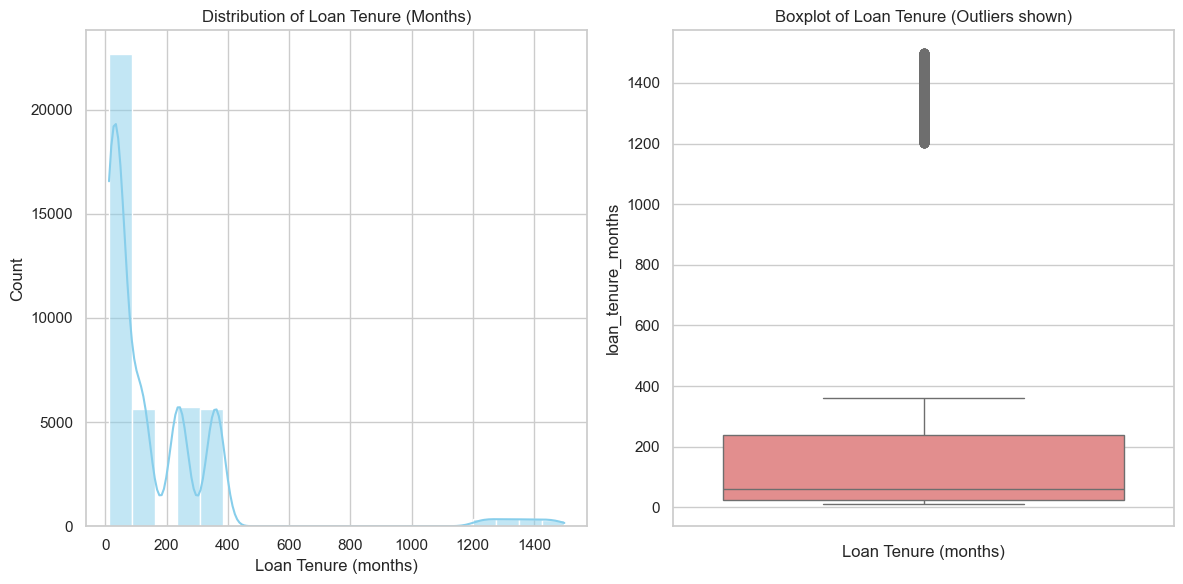

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


sns.histplot(df["loan_tenure_months"], bins=20, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Loan Tenure (Months)")
axes[0].set_xlabel("Loan Tenure (months)")
axes[0].set_ylabel("Count")


sns.boxplot(df["loan_tenure_months"], ax=axes[1], color="lightcoral", fliersize=6)
axes[1].set_title("Boxplot of Loan Tenure (Outliers shown)")
axes[1].set_xlabel("Loan Tenure (months)")

plt.tight_layout()
plt.show()

In [20]:
Q1 = df["loan_tenure_months"].quantile(0.25)
Q3 = df["loan_tenure_months"].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

outliers = df[df["loan_tenure_months"] > upper_limit]
df = df[df["loan_tenure_months"] <= upper_limit]

print(f"{len(outliers)} outliers found and removed from loan_tenure_months column")

duplicate_checked(df, cols_to_check)

1309 outliers found and removed from loan_tenure_months column
Duplicate rows: 0
Duplicate application_id values: 0 (0.0%)
Duplicate customer_id values: 22,425 (56.6%)


We decided to remove the extreme loan tenure values (over 600 months) because they are unrealistic and likely data entry errors.
This cleaning step ensures a more accurate and reliable analysis of typical loan durations.

### Missing Values

Monthly income and number of dependents are the only columns with notable missingness.

In [22]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(missing_pct=lambda s: s["missing_count"] / len(df) * 100)
      .query("missing_count > 0")
      .sort_values("missing_count", ascending=False)
)
missing_summary

,missing_count,missing_pct
number_of_dependents,3996,10.081490
monthly_income,3970,10.015894


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1278798279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=missing_plot, x="feature", y="missing_pct", palette="crest")


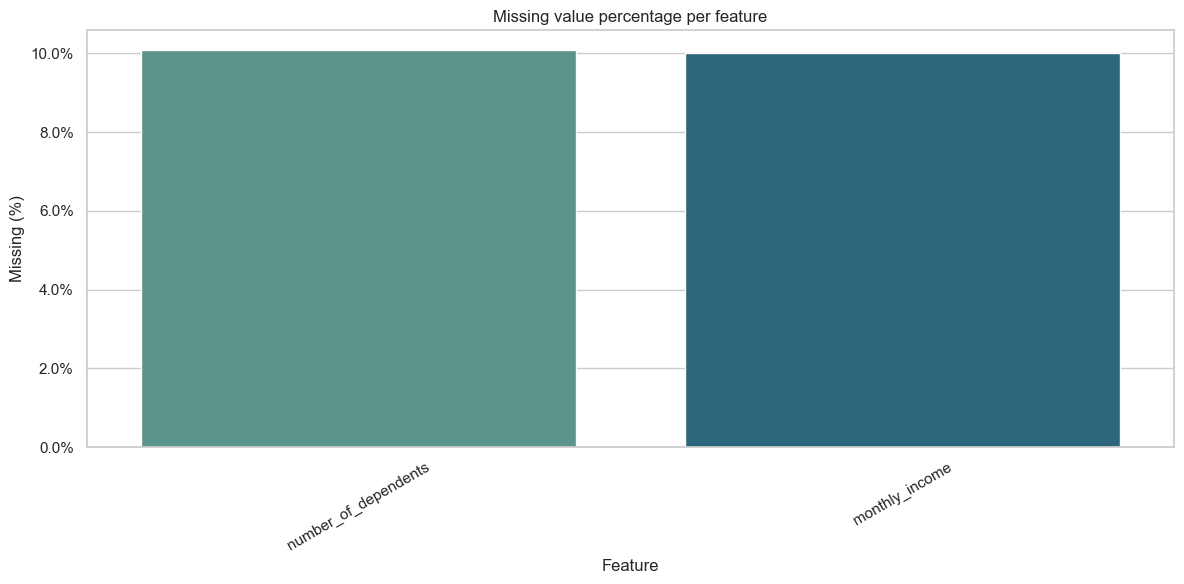

In [23]:
if not missing_summary.empty:
    missing_plot = missing_summary.reset_index().rename(columns={"index": "feature"})
    ax = sns.barplot(data=missing_plot, x="feature", y="missing_pct", palette="crest")
    ax.set_ylabel("Missing (%)")
    ax.set_xlabel("Feature")
    ax.set_title("Missing value percentage per feature")
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="x", rotation=30)
    plt.tight_layout()
    plt.show();
else:
    print("No missing values detected.")

Only monthly income (10.0 percent) and number of dependents (10.1 percent) need imputation strategies. All other features are complete.

## Feature Typing and Helper Columns

We engineer helper columns to simplify the analysis (for example, consolidate one-hot encoded loan types, derive temporal buckets, and create ratio measures).

In [24]:
# Consolidate one-hot encoded loan types
loan_type_cols = [col for col in df.columns if col.startswith("loan_type_")]
df["loan_type"] = (
    df[loan_type_cols]
      .idxmax(axis=1)
      .str.replace("loan_type_", "", regex=False)
      .str.replace("_", " ")
)

# Consolidate gender
df["gender"] = "Female"
df.loc[df["gender_Male"] == 1, "gender"] = "Male"
df.loc[df["gender_Other"] == 1, "gender"] = "Other"

# Temporal features
df["application_year"] = df["application_date"].dt.year
df["application_month"] = df["application_date"].dt.to_period("M").astype(str)
df["application_day_of_week"] = df["application_date"].dt.day_name()
df["application_quarter"] = df["application_date"].dt.quarter

# Application recency
latest_application_date = df["application_date"].max()
if pd.notna(latest_application_date):
    df["application_recency_days"] = (latest_application_date - df["application_date"]).dt.days

# Financial ratios - existing
df["loan_to_yearly_income"] = df["loan_amount_requested"] / df["yearly_income"].replace(0, np.nan)
df["emi_to_income_ratio"] = df["existing_emis_monthly"] / df["monthly_income"].replace(0, np.nan)
df["annual_bonus_ratio"] = df["annual_bonus"] / df["yearly_income"].replace(0, np.nan)

# NEW: Additional financial ratios
df["loan_to_monthly_income"] = df["loan_amount_requested"] / df["monthly_income"].replace(0, np.nan)
df["total_monthly_debt_ratio"] = (df["existing_emis_monthly"] + 
                                  (df["loan_amount_requested"] / df["loan_tenure_months"])) / df["monthly_income"].replace(0, np.nan)
df["age_to_tenure_ratio"] = df["applicant_age"] / df["loan_tenure_months"].replace(0, np.nan)
df["interest_vs_cibil"] = df["interest_rate_offered"] / (df["cibil_score"] / 100)

# Replace infinities with NaN in all ratio columns
ratio_cols = [col for col in df.columns if 'ratio' in col.lower() or 'to_' in col]
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan)

df[["loan_type", "gender", "application_date", "application_month", "application_day_of_week"]].head()

,loan_type,gender,application_date,application_month,application_day_of_week
0,Education Loan,Female,2025-02-19,2025-02,Wednesday
1,Personal Loan,Male,2024-02-09,2024-02,Friday
2,Home Loan,Female,2025-05-10,2025-05,Saturday
3,Car Loan,Female,2024-09-09,2024-09,Monday
4,Car Loan,Other,2023-10-14,2023-10,Saturday


The engineered columns confirm that loan types and genders were encoded as one-hot features, the application timeline spans June 2022 to June 2025. The new financial ratios will help detect applicants with stressed finances and anomalous patterns.

## Target Distribution

The target `fraud_flag` is binary. We inspect the class balance before drilling into drivers.

In [25]:
target_summary = (
    df["fraud_flag"]
      .value_counts()
      .rename_axis("fraud_flag")
      .to_frame("count")
      .assign(percentage=lambda s: s["count"] / len(df) * 100)
      .sort_index()
)
target_summary

,count,percentage
fraud_flag,,
0,34286,86.499987
1,5351,13.500013


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1815886200.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="fraud_flag", palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1815886200.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Legitimate (0)", "Fraudulent (1)"])


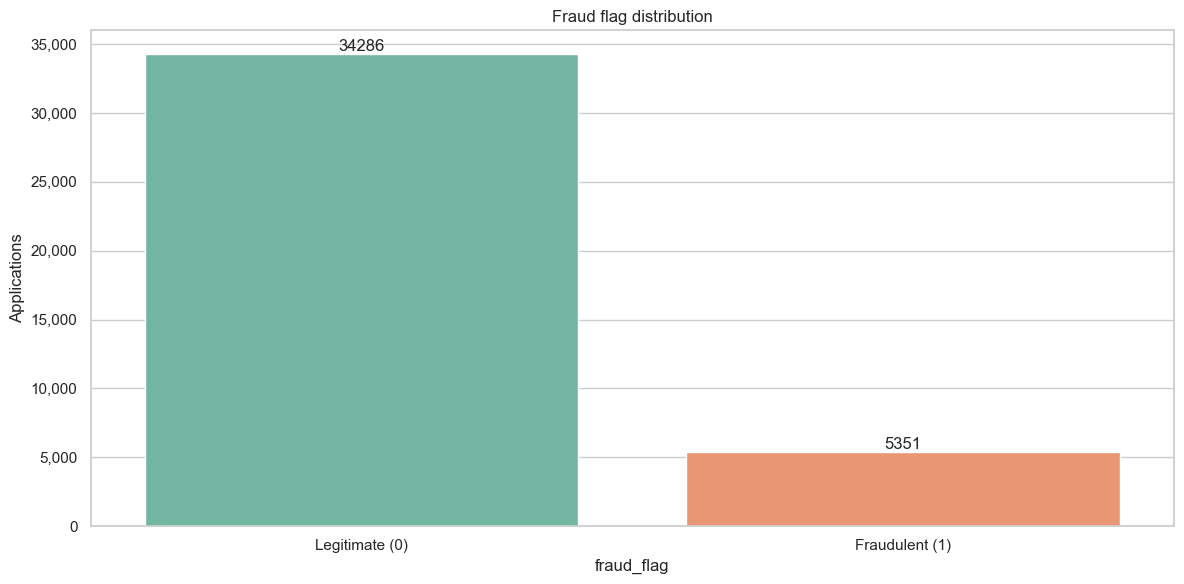

In [26]:
ax = sns.countplot(data=df, x="fraud_flag", palette="Set2")
ax.set_xticklabels(["Legitimate (0)", "Fraudulent (1)"])
ax.set_ylabel("Applications")
ax.set_title("Fraud flag distribution")
ax.yaxis.set_major_formatter(FuncFormatter(lambda value, _: f"{int(value):,}"))
for container in ax.containers:
    ax.bar_label(container, fmt="%d")
plt.tight_layout()
plt.show()

The dataset is mildly imbalanced: 13.5% fraudulent applications versus 86.5% legitimate ones. The positive class is sizeable but will still benefit from stratified cross-validation and class weighting during modeling.

# Customer Behavior Analysis

With 57.6% of customer_ids being duplicated, many customers have submitted multiple applications. Let's analyze recurrent customer behavior and detect potential serial fraudsters.

## Applications per Customer

In [27]:
# Calculate applications per customer
customer_behavior = (
    df.groupby('customer_id')
    .agg(
        num_applications=('application_id', 'nunique'),
        num_frauds=('fraud_flag', 'sum'),
        fraud_rate=('fraud_flag', 'mean'),
        first_application=('application_date', 'min'),
        last_application=('application_date', 'max'),
        avg_loan_amount=('loan_amount_requested', 'mean'),
        avg_cibil=('cibil_score', 'mean')
    )
    .reset_index()
)

# Calculate time span between first and last application
customer_behavior['application_span_days'] = (
    customer_behavior['last_application'] - customer_behavior['first_application']
).dt.days

# Categorize customers by fraud behavior
customer_behavior['customer_type'] = 'Clean'
customer_behavior.loc[
    (customer_behavior['num_frauds'] > 0) & (customer_behavior['num_frauds'] < customer_behavior['num_applications']),
    'customer_type'
] = 'Mixed'
customer_behavior.loc[
    customer_behavior['num_frauds'] == customer_behavior['num_applications'],
    'customer_type'
] = 'All Fraud'

print(f"Total unique customers: {len(customer_behavior):,}")
print(f"\nCustomer type distribution:")
print(customer_behavior['customer_type'].value_counts())
print(f"\nApplications per customer:")
customer_behavior['num_applications'].describe()

Total unique customers: 17,212

Customer type distribution:
customer_type
Clean        12745
Mixed         3493
All Fraud      974
Name: count, dtype: int64

Applications per customer:


count    17212.000000
mean         2.302870
std          1.242539
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: num_applications, dtype: float64

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/2736884431.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_by_apps_filtered, x='num_applications', y='avg_fraud_rate', ax=axes[1], palette='rocket')


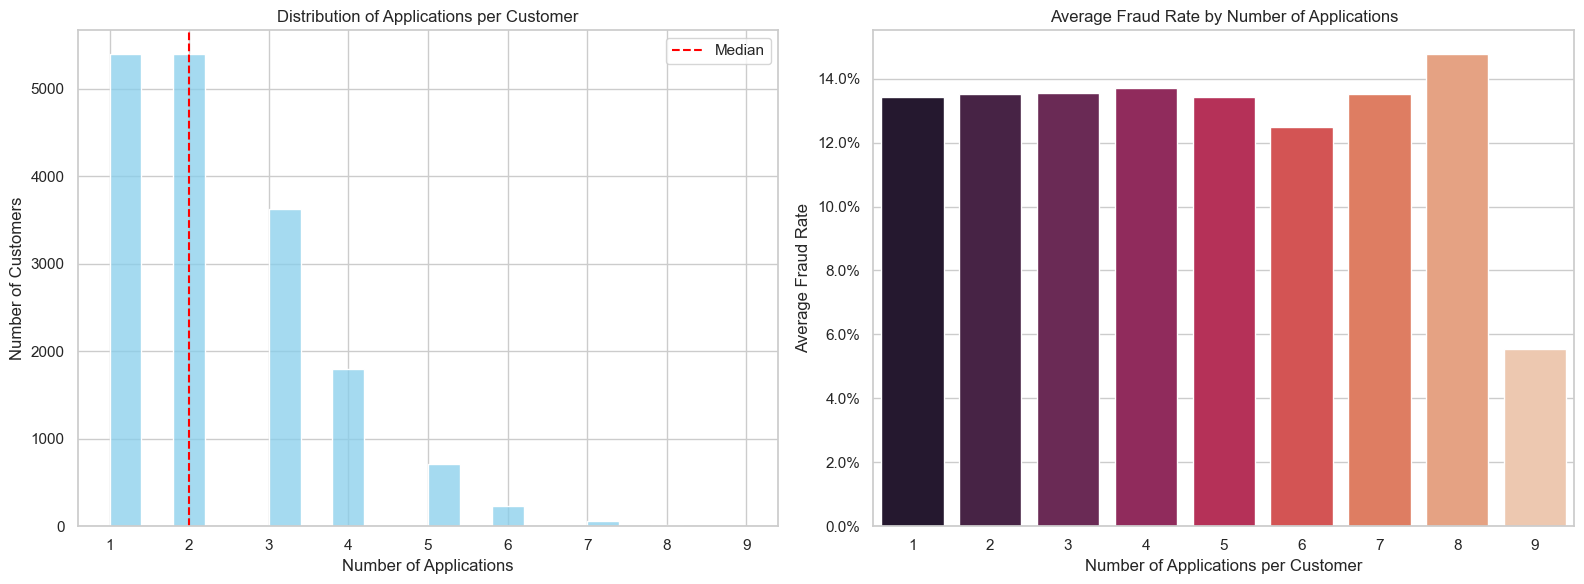

In [28]:
# Visualize fraud rate by number of applications
fraud_by_apps = (
    customer_behavior.groupby('num_applications')
    .agg(
        customer_count=('customer_id', 'count'),
        avg_fraud_rate=('fraud_rate', 'mean')
    )
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Number of applications distribution
sns.histplot(data=customer_behavior, x='num_applications', bins=20, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Applications per Customer')
axes[0].set_xlabel('Number of Applications')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(customer_behavior['num_applications'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Plot 2: Fraud rate by number of applications
fraud_by_apps_filtered = fraud_by_apps[fraud_by_apps['num_applications'] <= 10]
sns.barplot(data=fraud_by_apps_filtered, x='num_applications', y='avg_fraud_rate', ax=axes[1], palette='rocket')
axes[1].set_title('Average Fraud Rate by Number of Applications')
axes[1].set_xlabel('Number of Applications per Customer')
axes[1].set_ylabel('Average Fraud Rate')
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

## Serial Fraudsters Detection

In [29]:
# Identify serial fraudsters (customers with 2+ fraudulent applications)
serial_fraudsters = customer_behavior[customer_behavior['num_frauds'] >= 2].sort_values('num_frauds', ascending=False)

print(f"Serial fraudsters detected: {len(serial_fraudsters):,}")
print(f"Total fraud applications from serial fraudsters: {serial_fraudsters['num_frauds'].sum():,}")
print(f"\nTop 10 serial fraudsters:")
display(serial_fraudsters.head(10)[['customer_id', 'num_applications', 'num_frauds', 'fraud_rate', 'application_span_days']])

# Analyze customer type distribution
customer_type_summary = (
    customer_behavior.groupby('customer_type')
    .agg(
        count=('customer_id', 'count'),
        total_applications=('num_applications', 'sum'),
        total_frauds=('num_frauds', 'sum'),
        avg_fraud_rate=('fraud_rate', 'mean')
    )
    .reset_index()
)

print("\n\nCustomer type summary:")
display(customer_type_summary)

Serial fraudsters detected: 669
Total fraud applications from serial fraudsters: 1,553

Top 10 serial fraudsters:


,customer_id,num_applications,num_frauds,fraud_rate,application_span_days
12051,CUST114025,6,6,1.000000,998
10208,CUST111911,6,6,1.000000,240
3367,CUST103929,6,6,1.000000,616
12902,CUST115014,7,6,0.857143,773
9552,CUST111159,6,6,1.000000,968
10362,CUST112089,5,5,1.000000,857
16694,CUST119401,6,5,0.833333,787
8946,CUST110445,5,5,1.000000,905
14928,CUST117340,5,5,1.000000,569
8838,CUST110319,5,5,1.000000,983




Customer type summary:


,customer_type,count,total_applications,total_frauds,avg_fraud_rate
0,All Fraud,974,1368,1368,1.000000
1,Clean,12745,27083,0,0.000000
2,Mixed,3493,11186,3983,0.386285


# Data Consistency & Business Logic Checks

Let's verify that the data follows expected business rules and detect potential data quality issues or fraudulent patterns.

In [30]:
# Check 1: monthly_income * 12 vs yearly_income
df['income_mismatch'] = np.abs(df['monthly_income'] * 12 - df['yearly_income']) > 100
income_mismatches = df['income_mismatch'].sum()
income_mismatch_fraud_rate = df[df['income_mismatch'] == True]['fraud_flag'].mean() if income_mismatches > 0 else 0

# Check 2: Young retirees (retired but age < 50)
df['young_retired'] = (df['employment_status'] == 'Retired') & (df['applicant_age'] < 50)
young_retired_count = df['young_retired'].sum()
young_retired_fraud_rate = df[df['young_retired'] == True]['fraud_flag'].mean() if young_retired_count > 0 else 0

# Check 3: Students with very high income (> 75th percentile)
high_income_threshold = df['monthly_income'].quantile(0.75)
df['wealthy_student'] = (df['employment_status'] == 'Student') & (df['monthly_income'] > high_income_threshold)
wealthy_student_count = df['wealthy_student'].sum()
wealthy_student_fraud_rate = df[df['wealthy_student'] == True]['fraud_flag'].mean() if wealthy_student_count > 0 else 0

# Check 4: High CIBIL score but high interest rate (anomaly in pricing)
high_cibil_threshold = df['cibil_score'].quantile(0.75)
high_interest_threshold = df['interest_rate_offered'].quantile(0.75)
df['pricing_anomaly'] = (df['cibil_score'] > high_cibil_threshold) & (df['interest_rate_offered'] > high_interest_threshold)
pricing_anomaly_count = df['pricing_anomaly'].sum()
pricing_anomaly_fraud_rate = df[df['pricing_anomaly'] == True]['fraud_flag'].mean() if pricing_anomaly_count > 0 else 0

# Check 5: Very young applicants (< 25) with home loans
df['young_homebuyer'] = (df['applicant_age'] < 25) & (df['loan_type'] == 'Home Loan')
young_homebuyer_count = df['young_homebuyer'].sum()
young_homebuyer_fraud_rate = df[df['young_homebuyer'] == True]['fraud_flag'].mean() if young_homebuyer_count > 0 else 0

# Check 6: Unemployed with zero EMIs (suspect if asking for large loans)
high_loan_threshold = df['loan_amount_requested'].quantile(0.75)
df['unemployed_zero_emi'] = (df['employment_status'] == 'Unemployed') & (df['existing_emis_monthly'] == 0) & (df['loan_amount_requested'] > high_loan_threshold)
unemployed_zero_emi_count = df['unemployed_zero_emi'].sum()
unemployed_zero_emi_fraud_rate = df[df['unemployed_zero_emi'] == True]['fraud_flag'].mean() if unemployed_zero_emi_count > 0 else 0

# Summary table
consistency_checks = pd.DataFrame({
    'Check': [
        'Income mismatch (monthly*12 ≠ yearly)',
        'Young retirees (age < 50)',
        'Students with high income',
        'High CIBIL + High interest rate',
        'Young homebuyers (age < 25)',
        'Unemployed, zero EMI, large loan'
    ],
    'Count': [
        income_mismatches,
        young_retired_count,
        wealthy_student_count,
        pricing_anomaly_count,
        young_homebuyer_count,
        unemployed_zero_emi_count
    ],
    'Fraud Rate': [
        income_mismatch_fraud_rate,
        young_retired_fraud_rate,
        wealthy_student_fraud_rate,
        pricing_anomaly_fraud_rate,
        young_homebuyer_fraud_rate,
        unemployed_zero_emi_fraud_rate
    ],
    'Overall Fraud Rate': [df['fraud_flag'].mean()] * 6
})

consistency_checks['Fraud Rate'] = consistency_checks['Fraud Rate'].apply(lambda x: f"{x:.1%}")
consistency_checks['Overall Fraud Rate'] = consistency_checks['Overall Fraud Rate'].apply(lambda x: f"{x:.1%}")

print("Business Logic Consistency Checks:\n")
display(consistency_checks)

Business Logic Consistency Checks:



,Check,Count,Fraud Rate,Overall Fraud Rate
0,Income mismatch (monthly*12 ≠ yearly),0,0.0%,13.5%
1,Young retirees (age < 50),4463,13.3%,13.5%
2,Students with high income,1417,14.0%,13.5%
3,High CIBIL + High interest rate,2436,12.1%,13.5%
4,Young homebuyers (age < 25),723,11.2%,13.5%
5,"Unemployed, zero EMI, large loan",126,16.7%,13.5%


# Geographic Analysis

Extract city information from residential addresses to identify high-risk geographic regions.

In [31]:
# Extract city from residential_address (format: "address, City-PIN, State, ...")
# City is typically after the first comma and before the dash
def extract_city(address):
    try:
        # Split by comma and take the second part (after street address)
        parts = str(address).split(',')
        if len(parts) >= 2:
            # The city is usually in format "City-PIN" or just before the PIN
            city_part = parts[1].strip()
            # Remove PIN code (format: -XXXXXX)
            city = city_part.split('-')[0].strip()
            return city
    except:
        return np.nan
    return np.nan

df['city'] = df['residential_address'].apply(extract_city)

# Analyze fraud rate by city (top 20 cities)
city_fraud_analysis = (
    df.groupby('city')
    .agg(
        application_count=('fraud_flag', 'count'),
        fraud_count=('fraud_flag', 'sum'),
        fraud_rate=('fraud_flag', 'mean')
    )
    .reset_index()
    .sort_values('application_count', ascending=False)
)

# Filter cities with at least 50 applications for reliability
city_fraud_filtered = city_fraud_analysis[city_fraud_analysis['application_count'] >= 50].copy()

print(f"Total unique cities: {df['city'].nunique()}")
print(f"\nTop 20 cities by application volume:")
display(city_fraud_filtered.head(20))

# Find high-risk cities (fraud rate > overall average)
overall_fraud_rate = df['fraud_flag'].mean()
high_risk_cities = city_fraud_filtered[city_fraud_filtered['fraud_rate'] > overall_fraud_rate * 1.2]
print(f"\n\nHigh-risk cities (fraud rate > {overall_fraud_rate*1.2:.1%}):")
print(f"Count: {len(high_risk_cities)}")
display(high_risk_cities.head(10))

Total unique cities: 4380

Top 20 cities by application volume:


,city,application_count,fraud_count,fraud_rate
2056,Kala Zila,51,6,0.117647




High-risk cities (fraud rate > 16.2%):
Count: 0


,city,application_count,fraud_count,fraud_rate


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1630376291.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cities_fraud, y='city', x='fraud_rate', ax=axes[0], palette='Reds_r')


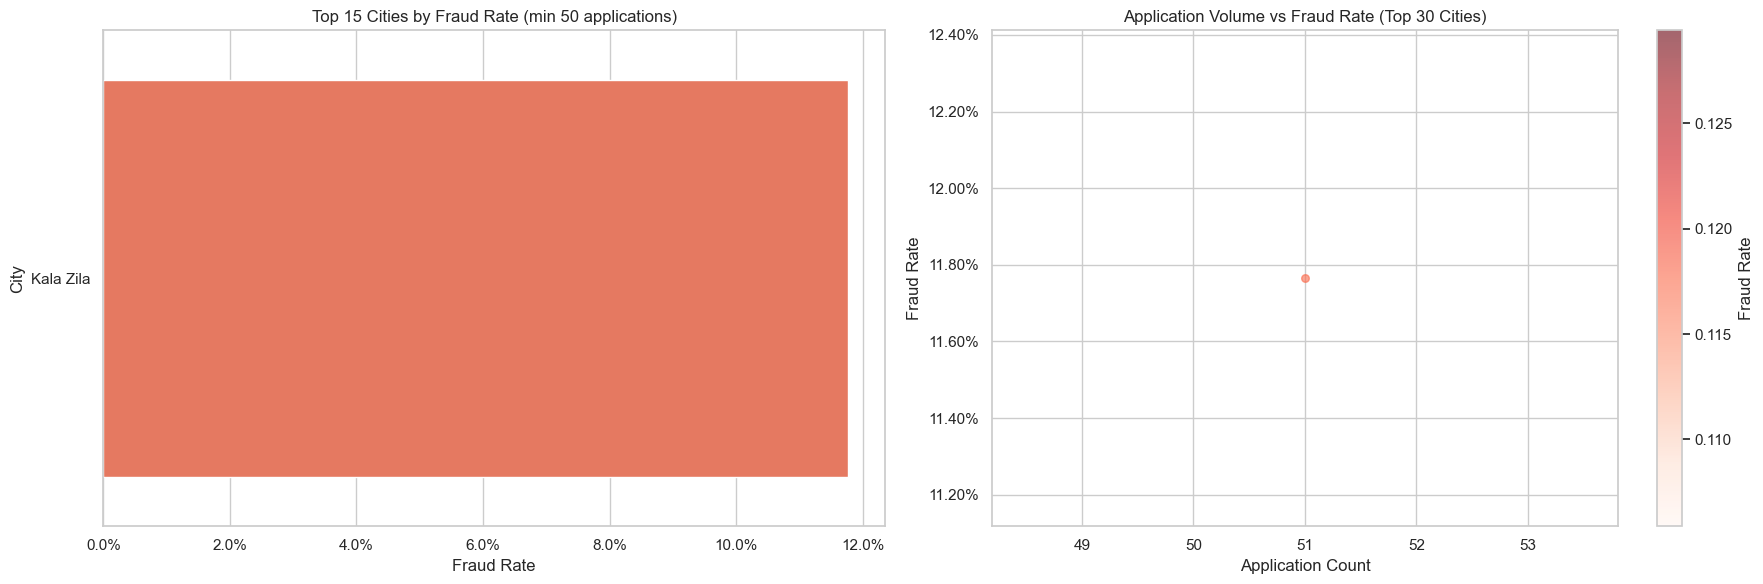

In [32]:
# Visualize top cities by fraud rate
top_cities_fraud = city_fraud_filtered.nlargest(15, 'fraud_rate')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top 15 cities by fraud rate
sns.barplot(data=top_cities_fraud, y='city', x='fraud_rate', ax=axes[0], palette='Reds_r')
axes[0].set_title('Top 15 Cities by Fraud Rate (min 50 applications)')
axes[0].set_xlabel('Fraud Rate')
axes[0].set_ylabel('City')
axes[0].xaxis.set_major_formatter(PercentFormatter(1.0))

# Plot 2: Application volume vs fraud rate for top 30 cities
top_30_cities = city_fraud_filtered.head(30)
scatter = axes[1].scatter(top_30_cities['application_count'], 
                          top_30_cities['fraud_rate'], 
                          s=top_30_cities['fraud_count']*5,
                          alpha=0.6, 
                          c=top_30_cities['fraud_rate'],
                          cmap='Reds')
axes[1].set_xlabel('Application Count')
axes[1].set_ylabel('Fraud Rate')
axes[1].set_title('Application Volume vs Fraud Rate (Top 30 Cities)')
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
plt.colorbar(scatter, ax=axes[1], label='Fraud Rate')

plt.tight_layout()
plt.show()

## Numerical Feature Summary

In [33]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_summary = df[numeric_cols].describe().T
missing_pct = df[numeric_cols].isna().mean() * 100
skewness = df[numeric_cols].skew()
numeric_summary["missing_pct"] = missing_pct
numeric_summary["skew"] = skewness
numeric_summary

,count,mean,std,min,25%,50%,75%,max,missing_pct,skew
loan_amount_requested,39637.0,515522.3125,327824.90625,100000.0,300000.0,503000.0,701000.0,25410000.0,0.000000,20.298037
loan_tenure_months,39637.0,121.553094,121.423618,12.0,24.0,60.0,240.0,360.0,0.000000,0.958742
interest_rate_offered,39637.0,10.526348,1.993907,5.27,9.1,10.5,11.89,18.23,0.000000,0.160261
monthly_income,35667.0,50747.148438,23840.884766,10000.0,33500.0,50200.0,67200.0,162000.0,10.015894,0.255197
cibil_score,39637.0,699.031208,50.108209,484.0,665.0,699.0,733.0,889.0,0.000000,-0.009732
existing_emis_monthly,39637.0,3057.060303,1893.458008,0.0,1600.0,3000.0,4400.0,11400.0,0.000000,0.306331
debt_to_income_ratio,39637.0,8.555975,9.582182,0.0,3.06,5.94,10.28,102.0,0.000000,2.873332
applicant_age,39637.0,43.063224,12.967522,21.0,32.0,43.0,54.0,65.0,0.000000,-0.009398
number_of_dependents,35641.0,2.012682,1.406298,0.0,1.0,2.0,3.0,4.0,10.081490,-0.008512
loan_type_Car Loan,39637.0,0.199359,0.399524,0.0,0.0,0.0,0.0,1.0,0.000000,1.505072


Monthly income and yearly income are perfectly collinear (yearly income equals monthly income multiplied by 12), and `loan_amount_usd` is tightly linked to `loan_amount_requested` (exchange rate of about 1.08).

### Distribution of Key Continuous Variables

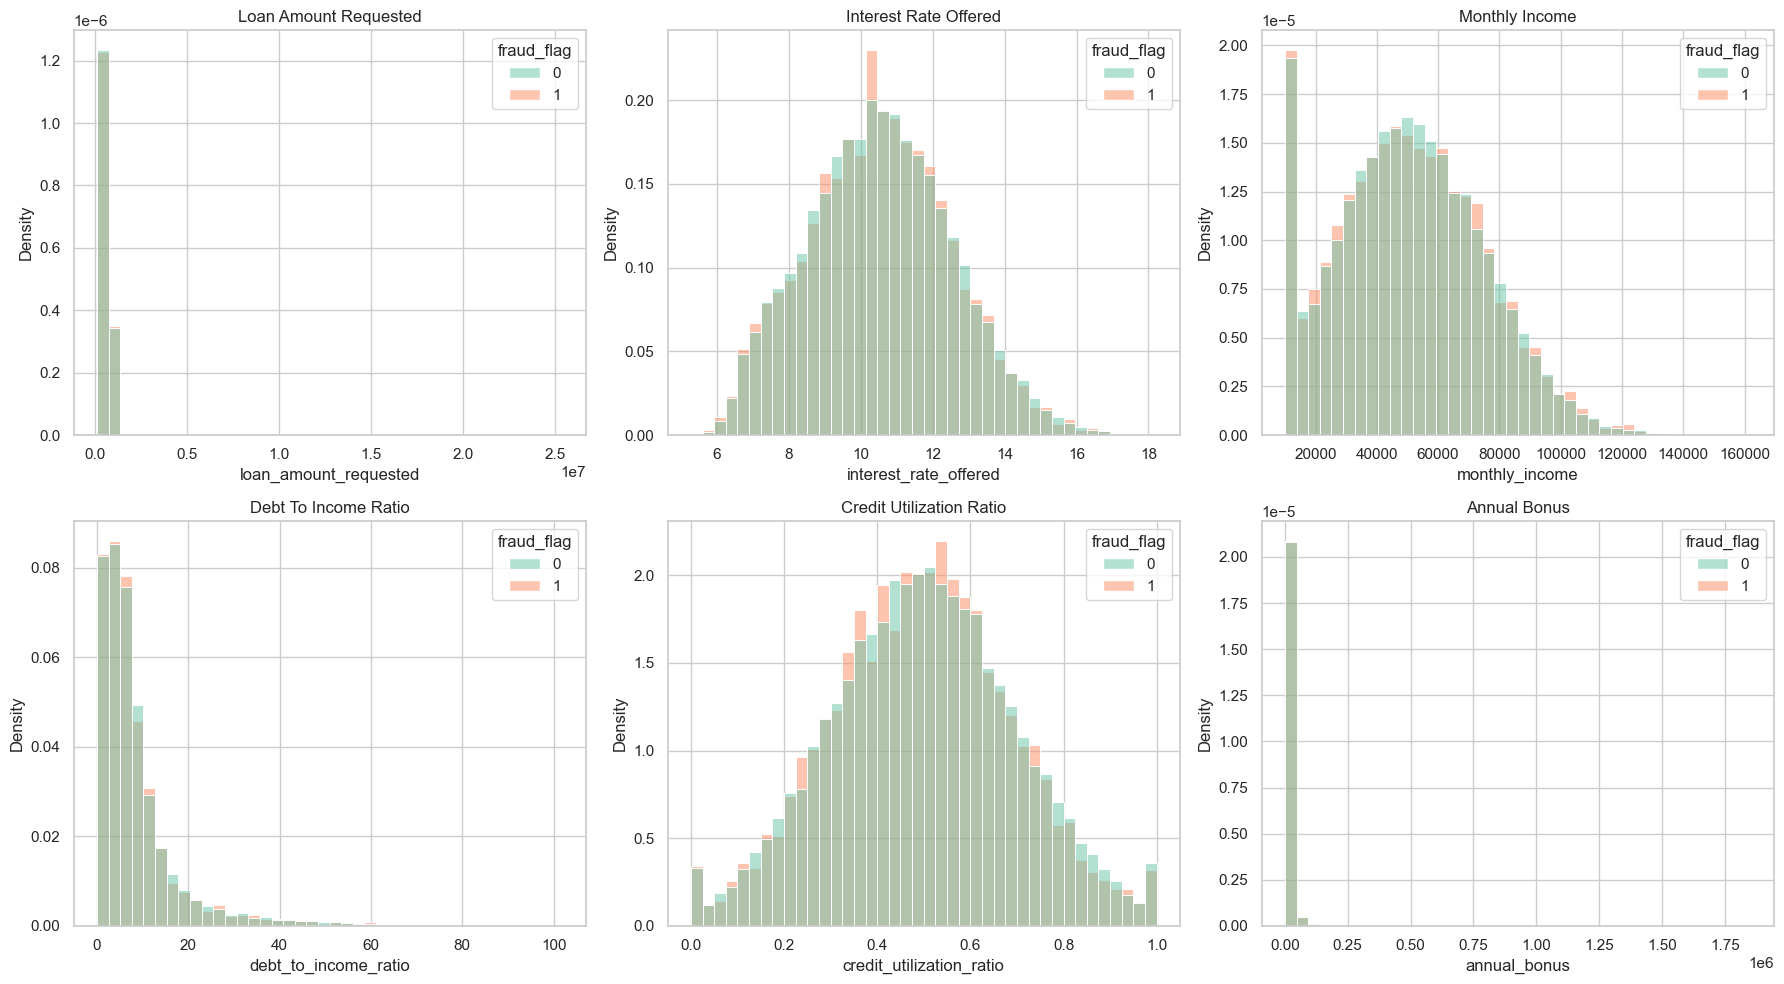

In [34]:
continuous_features = [
    "loan_amount_requested",
    "interest_rate_offered",
    "monthly_income",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "annual_bonus"
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flat, continuous_features):
    sns.histplot(
        data=df,
        x=col,
        bins=40,
        hue="fraud_flag",
        stat="density",
        common_norm=False,
        palette="Set2",
        ax=ax
    )
    ax.set_title(col.replace("_", " " ).title())
plt.tight_layout()
plt.show()

Loan amounts, income, and annual bonuses present long right tails, while interest rates and credit utilisation concentrate in narrow bands. Differences between fraud and legitimate applications are subtle in raw distributions, pointing to the need for interaction features.

## Categorical Feature Overview

In [35]:
categorical_cols = [
    "purpose_of_loan",
    "employment_status",
    "property_ownership_status",
    "loan_type",
    "gender",
    "data_batch_id"
]

cat_summary = []
for col in categorical_cols:
    vc = df[col].value_counts(dropna=False)
    top_value = vc.index[0] if not vc.empty else np.nan
    cat_summary.append({
        "feature": col,
        "unique": vc.shape[0],
        "top_value": top_value,
        "top_count": int(vc.iloc[0]) if not vc.empty else 0,
        "top_fraction": (vc.iloc[0] / len(df)) if not vc.empty else np.nan
    })
cat_summary = pd.DataFrame(cat_summary)
cat_summary

,feature,unique,top_value,top_count,top_fraction
0,purpose_of_loan,7,Debt Consolidation,5723,0.144385
1,employment_status,6,Salaried,6773,0.170876
2,property_ownership_status,3,Rented,13253,0.334359
3,loan_type,4,Car Loan,15723,0.396675
4,gender,3,Other,13435,0.338951
5,data_batch_id,1,batch_20250926_A,39637,1.000000


In [36]:
high_cardinality = df[["application_id", "customer_id", "residential_address"]].nunique()
high_cardinality.to_frame(name="unique_values")

,unique_values
application_id,39637
customer_id,17212
residential_address,17212


### Fraud Rate by Categorical Feature

In [37]:
cat_features = ["purpose_of_loan", "employment_status", "property_ownership_status", "loan_type", "gender"]
for col in cat_features:
    summary = (
        df.groupby(col)["fraud_flag"]
          .agg(count="size", fraud_rate="mean")
          .sort_values("fraud_rate", ascending=False)
    )
    print(f"Fraud rate by {col}:")
    display(summary)


Fraud rate by purpose_of_loan:


,count,fraud_rate
purpose_of_loan,,
Home Renovation,5685,0.143360
Business Expansion,5608,0.138374
Medical Emergency,5668,0.136556
Education,5658,0.135207
Debt Consolidation,5723,0.130701
Wedding,5708,0.130519
Vehicle Purchase,5587,0.130302


Fraud rate by employment_status:


,count,fraud_rate
employment_status,,
Salaried,6773,0.140115
Business Owner,6601,0.137100
Retired,6749,0.135279
Student,6388,0.133845
Self-Employed,6523,0.131841
Unemployed,6603,0.131607


Fraud rate by property_ownership_status:


,count,fraud_rate
property_ownership_status,,
Jointly Owned,13213,0.139257
Rented,13253,0.135139
Owned,13171,0.130590


Fraud rate by loan_type:


,count,fraud_rate
loan_type,,
Personal Loan,7985,0.137383
Education Loan,7916,0.135169
Home Loan,8013,0.135155
Car Loan,15723,0.133626


Fraud rate by gender:


,count,fraud_rate
gender,,
Other,13435,0.135169
Male,12967,0.135112
Female,13235,0.134719


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="frau

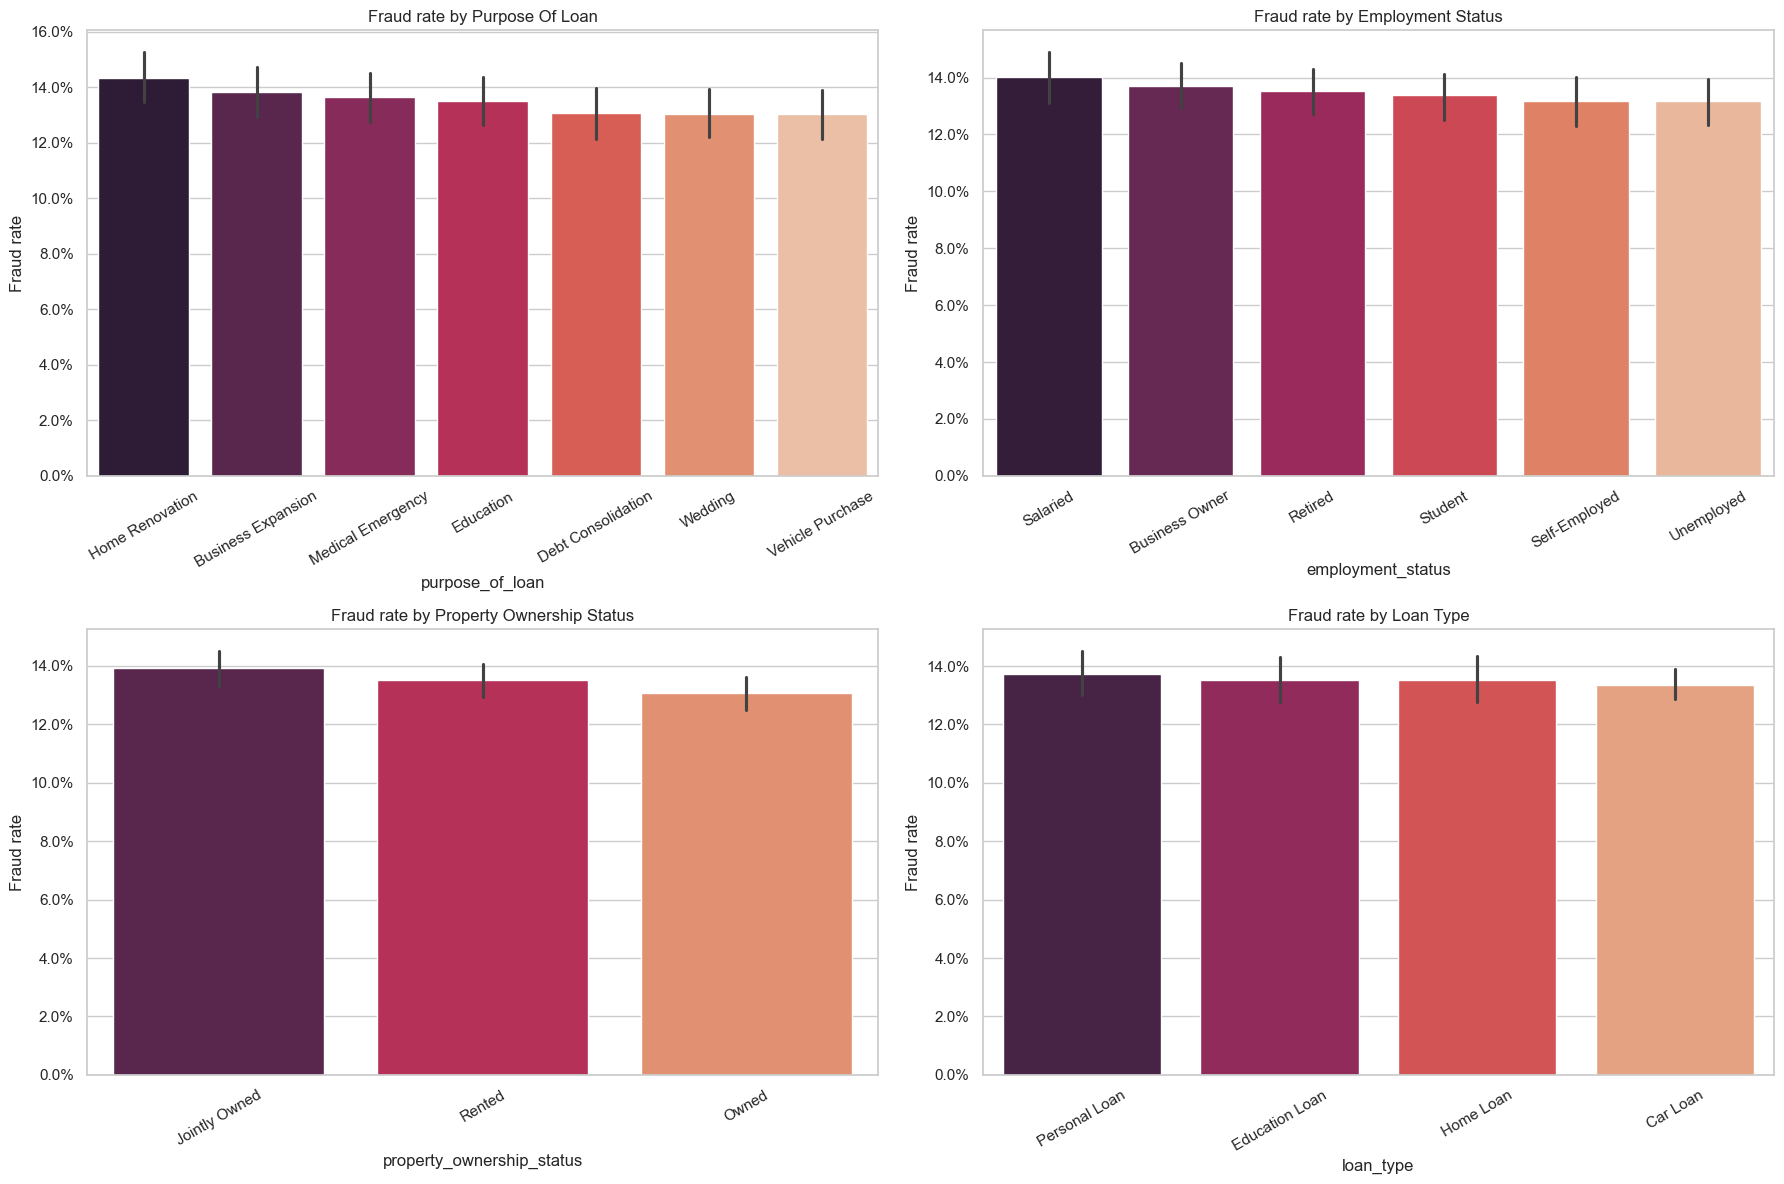

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, col in zip(axes.flat, cat_features[:4]):
    order = (
        df.groupby(col)["fraud_flag"]
          .mean()
          .sort_values(ascending=False)
          .index
    )
    sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
    ax.set_title(f"Fraud rate by {col.replace('_', ' ').title()}")
    ax.set_ylabel("Fraud rate")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis="x", rotation=30);
plt.tight_layout()
plt.show()

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/1095939919.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="gender", y="fraud_flag", palette="rocket")


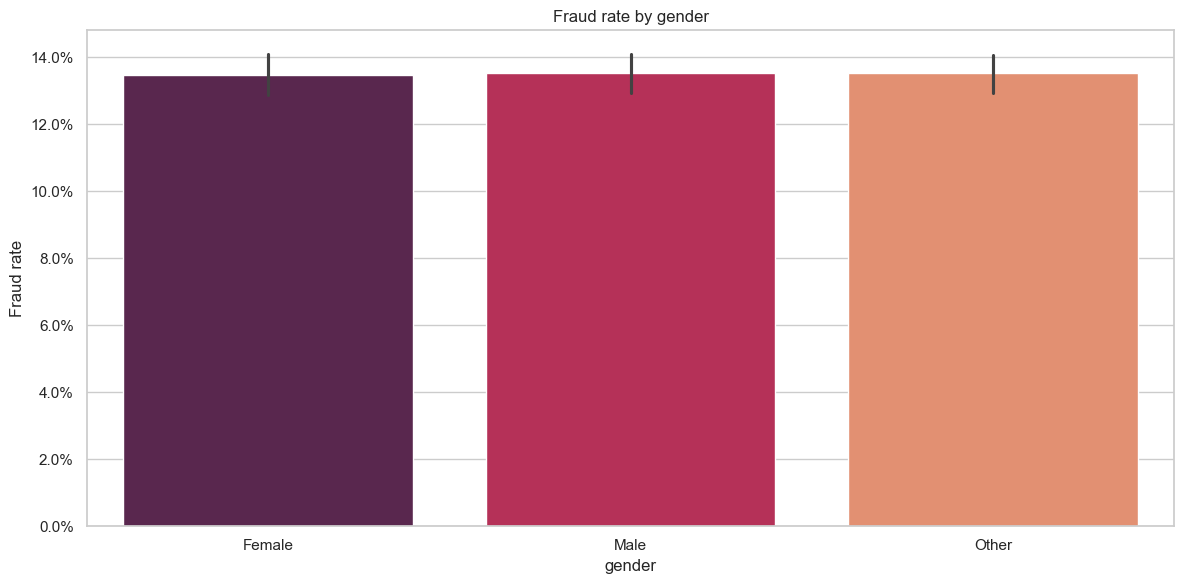

In [39]:
ax = sns.barplot(data=df, x="gender", y="fraud_flag", palette="rocket")
ax.set_title("Fraud rate by gender")
ax.set_ylabel("Fraud rate")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout();plt.show()


## Cross-Categorical Fraud Rate Analysis

Analyze fraud rates across combinations of categorical variables to identify high-risk segments.

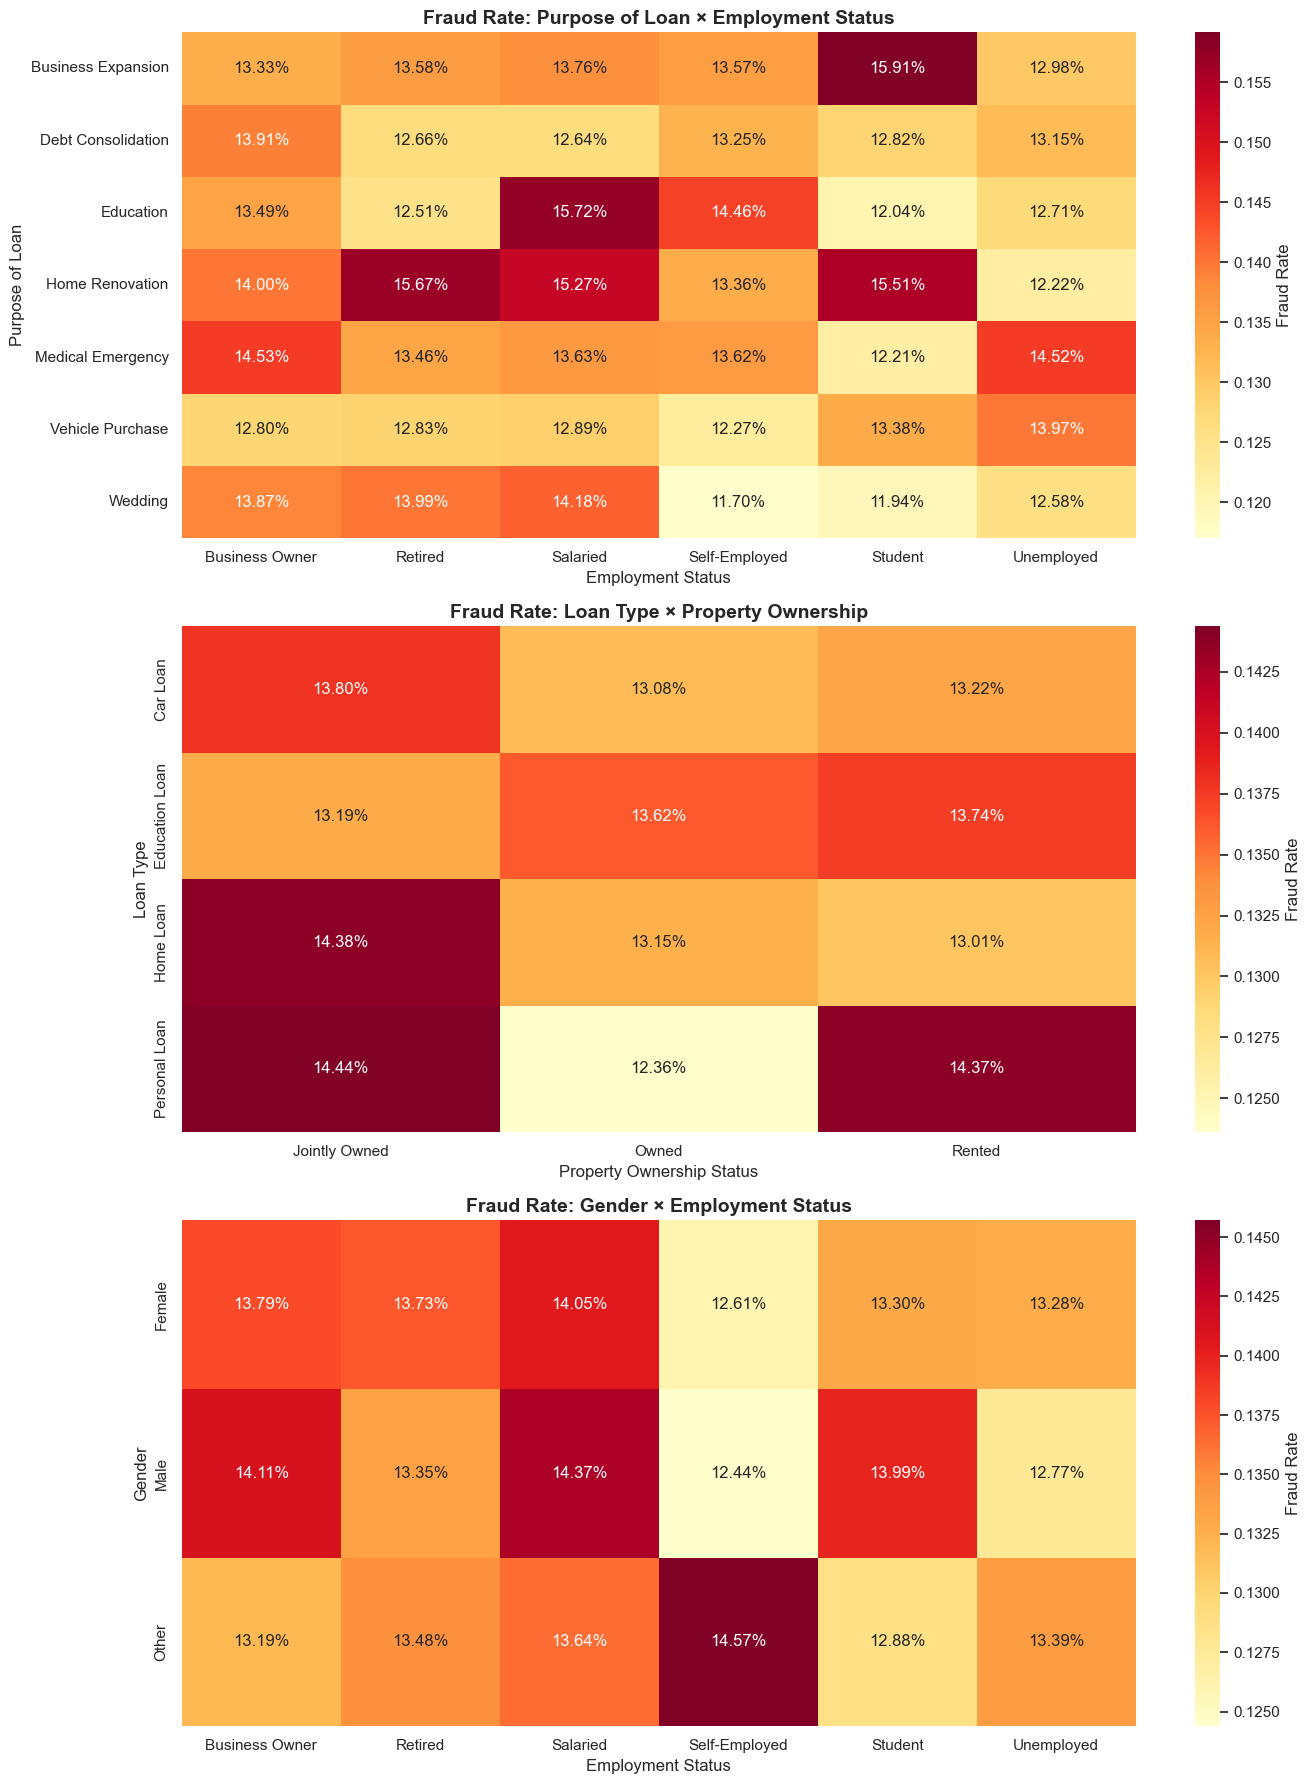

In [40]:
# Create pivot tables for cross-categorical analysis

# 1. Purpose of loan × Employment status
fraud_pivot_1 = df.pivot_table(
    values='fraud_flag',
    index='purpose_of_loan',
    columns='employment_status',
    aggfunc='mean'
)

# 2. Loan type × Property ownership
fraud_pivot_2 = df.pivot_table(
    values='fraud_flag',
    index='loan_type',
    columns='property_ownership_status',
    aggfunc='mean'
)

# 3. Gender × Employment status
fraud_pivot_3 = df.pivot_table(
    values='fraud_flag',
    index='gender',
    columns='employment_status',
    aggfunc='mean'
)

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Heatmap 1
sns.heatmap(fraud_pivot_1, annot=True, fmt='.2%', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Fraud Rate'})
axes[0].set_title('Fraud Rate: Purpose of Loan × Employment Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Employment Status')
axes[0].set_ylabel('Purpose of Loan')

# Heatmap 2
sns.heatmap(fraud_pivot_2, annot=True, fmt='.2%', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Fraud Rate'})
axes[1].set_title('Fraud Rate: Loan Type × Property Ownership', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Property Ownership Status')
axes[1].set_ylabel('Loan Type')

# Heatmap 3
sns.heatmap(fraud_pivot_3, annot=True, fmt='.2%', cmap='YlOrRd', ax=axes[2], cbar_kws={'label': 'Fraud Rate'})
axes[2].set_title('Fraud Rate: Gender × Employment Status', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Employment Status')
axes[2].set_ylabel('Gender')

plt.tight_layout()
plt.show()

Home renovation and education loans show the highest fraud rates (around 20 percent), while wedding loans are the lowest. Business owners, retirees, and salaried applicants edge higher than self-employed applicants. Property ownership labels were case-sensitive; after harmonising the text we still see joint ownership and renting associated with slightly higher risk.

## Temporal Patterns

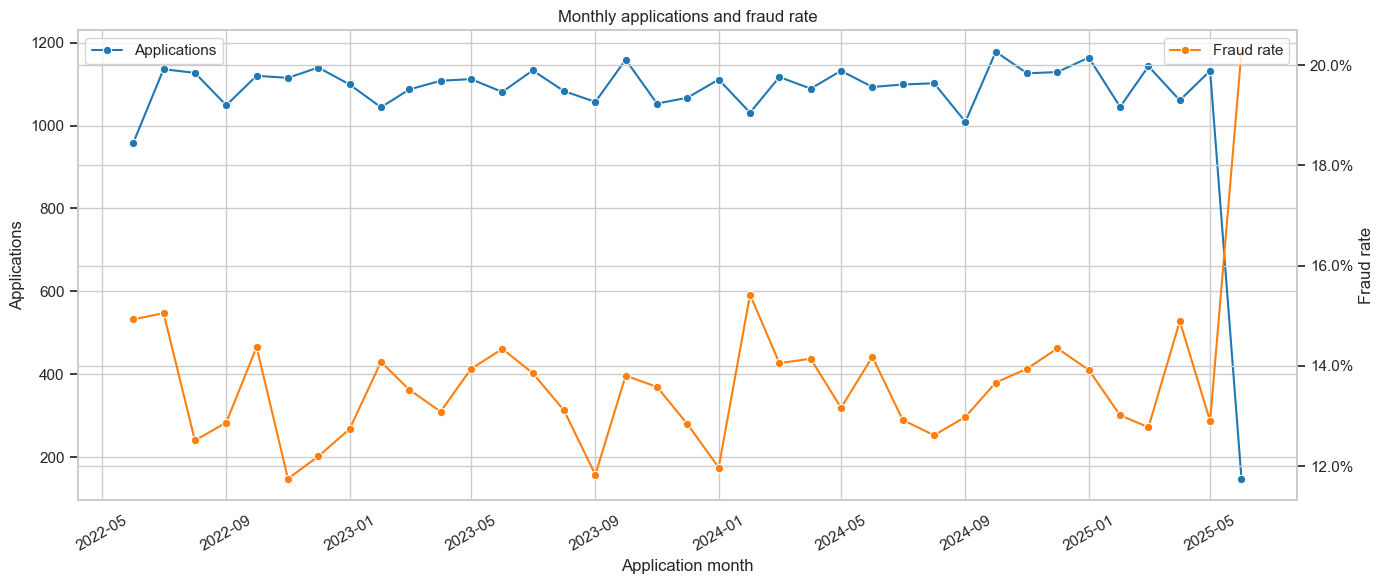

In [41]:
monthly_trend = (
    df.groupby("application_month")
      .agg(applications=("fraud_flag", "size"), fraud_rate=("fraud_flag", "mean"))
      .reset_index()
      .sort_values("application_month")
)
monthly_trend["application_month"] = pd.to_datetime(monthly_trend["application_month"])

fig, ax1 = plt.subplots(figsize=(14, 6))
sns.lineplot(data=monthly_trend, x="application_month", y="applications", marker="o", ax=ax1, color="tab:blue", label="Applications")
ax1.set_ylabel("Applications")
ax1.set_xlabel("Application month")
ax1.tick_params(axis="x", rotation=30)

ax2 = ax1.twinx()
sns.lineplot(data=monthly_trend, x="application_month", y="fraud_rate", marker="o", ax=ax2, color="tab:orange", label="Fraud rate")
ax2.set_ylabel("Fraud rate")
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

ax1.set_title("Monthly applications and fraud rate")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [42]:
df.application_year.value_counts().sort_index()

application_year
2022     7645
2023    13083
2024    13216
2025     5693
Name: count, dtype: int64

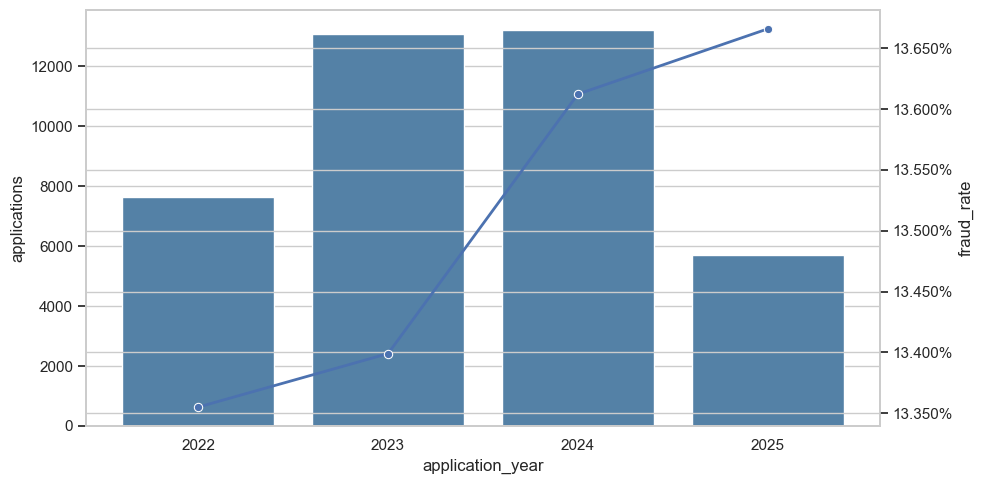

In [43]:
yearly_summary = (
    df.groupby("application_year")["fraud_flag"]
      .agg(applications="size", fraud_rate="mean")
      .reset_index()
      .sort_values("application_year")
)


order = yearly_summary["application_year"].astype(str).tolist()
yearly_summary["year_cat"] = pd.Categorical(yearly_summary["application_year"].astype(str), categories=order, ordered=True)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=yearly_summary, x="year_cat", y="applications", color="steelblue", ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=yearly_summary, x="year_cat", y="fraud_rate", marker="o", linewidth=2, ax=ax2)
ax.set_xlabel("application_year")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout(); plt.show()

## Day of Week Analysis

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/607583138.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_analysis, x='application_day_of_week', y='application_count', ax=axes[0], palette='Blues_d')
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/607583138.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_analysis, x='application_day_of_week', y='fraud_rate', ax=axes[1], palette='Reds_d')


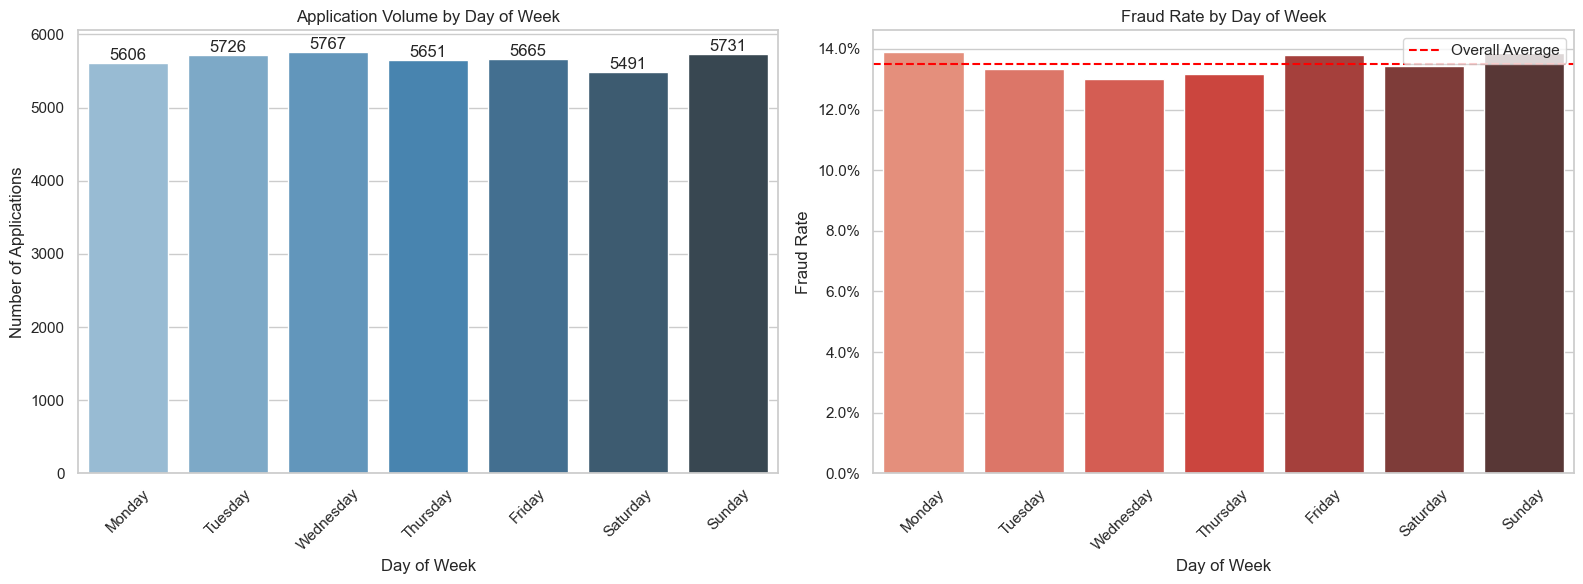


Day of Week Summary:


,application_day_of_week,application_count,fraud_rate
1,Monday,5606,0.139137
5,Tuesday,5726,0.133426
6,Wednesday,5767,0.130050
4,Thursday,5651,0.131835
0,Friday,5665,0.137864
2,Saturday,5491,0.134220
3,Sunday,5731,0.138545


In [44]:
# Analyze fraud patterns by day of week
dow_analysis = (
    df.groupby('application_day_of_week')
    .agg(
        application_count=('fraud_flag', 'count'),
        fraud_rate=('fraud_flag', 'mean')
    )
    .reset_index()
)

# Order by weekday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_analysis['application_day_of_week'] = pd.Categorical(dow_analysis['application_day_of_week'], categories=day_order, ordered=True)
dow_analysis = dow_analysis.sort_values('application_day_of_week')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Application volume by day of week
sns.barplot(data=dow_analysis, x='application_day_of_week', y='application_count', ax=axes[0], palette='Blues_d')
axes[0].set_title('Application Volume by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Applications')
axes[0].tick_params(axis='x', rotation=45)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Plot 2: Fraud rate by day of week
sns.barplot(data=dow_analysis, x='application_day_of_week', y='fraud_rate', ax=axes[1], palette='Reds_d')
axes[1].set_title('Fraud Rate by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Fraud Rate')
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(df['fraud_flag'].mean(), color='red', linestyle='--', label='Overall Average')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nDay of Week Summary:")
display(dow_analysis)

Application volume peaks in 2023 and 2024, with a small 2025 sample that inflates the last observed fraud rate (27 percent in June 2025 on just 168 applications). Fraud rates otherwise oscillate between 18 and 21 percent, suggesting seasonality is limited.

## Correlation and Multivariate Analysis

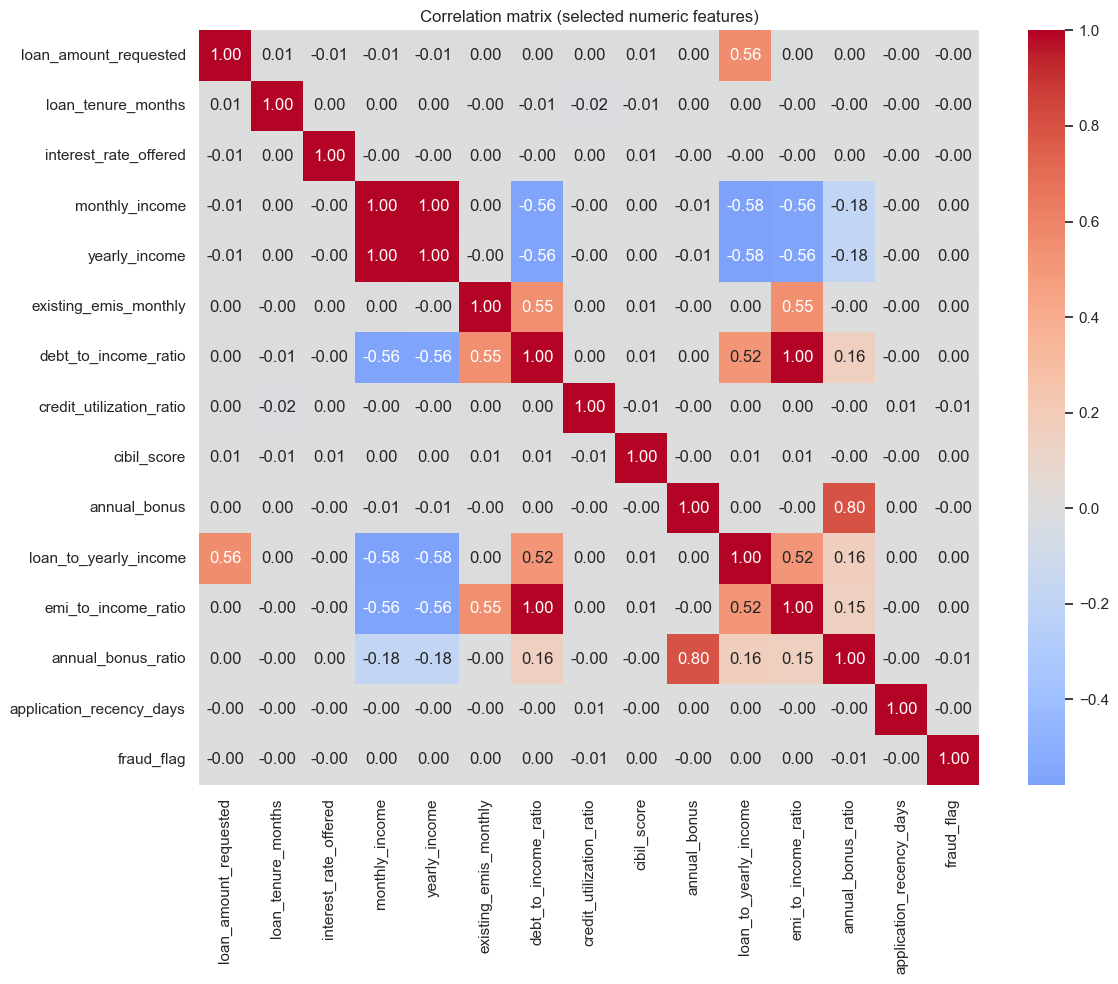

In [45]:
selected_numeric = [
    "loan_amount_requested",
    "loan_tenure_months",
    "interest_rate_offered",
    "monthly_income",
    "yearly_income",
    "existing_emis_monthly",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "cibil_score",
    "annual_bonus",
    "loan_to_yearly_income",
    "emi_to_income_ratio",
    "annual_bonus_ratio",
    "application_recency_days",
    "fraud_flag"
]

corr_matrix = df[selected_numeric].corr()
corr_matrix = corr_matrix.dropna(how="all", axis=0).dropna(how="all", axis=1)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation matrix (selected numeric features)")
plt.tight_layout()
plt.show()

Correlations with `fraud_flag` are weak (< 0.01 in absolute value), underscoring that univariate relationships are subtle and will likely require interaction terms or nonlinear models. The heatmap also surfaces redundant pairs such as monthly income vs yearly income and loan amount vs loan amount in USD.

### Fraud vs Numeric Features

In [46]:
fraud_focus_cols = [
    "loan_amount_requested",
    "interest_rate_offered",
    "monthly_income",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "loan_to_yearly_income",
    "emi_to_income_ratio"
]

fraud_numeric_summary = (
    df.groupby("fraud_flag")[fraud_focus_cols]
      .agg(["mean", "median"])
      .T
      .rename_axis(["feature", "statistic"])
)
fraud_numeric_summary

fraud_flag                                      0              1
feature                  statistic                              
loan_amount_requested    mean       515657.250000  514657.656250
                         median     502000.000000  506000.000000
interest_rate_offered    mean           10.529560      10.505763
                         median         10.500000      10.480000
monthly_income           mean        50745.324219   50758.812500
                         median      50200.000000   49900.000000
debt_to_income_ratio     mean            8.553192       8.573809
                         median          5.960000       5.880000
credit_utilization_ratio mean            0.499023       0.494690
                         median          0.498492       0.496621
loan_to_yearly_income    mean            1.203004       1.211727
                         median          0.833333       0.833333
emi_to_income_ratio      mean            0.085456       0.085820
                         median          0.059350       0.058824

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_15337/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2"

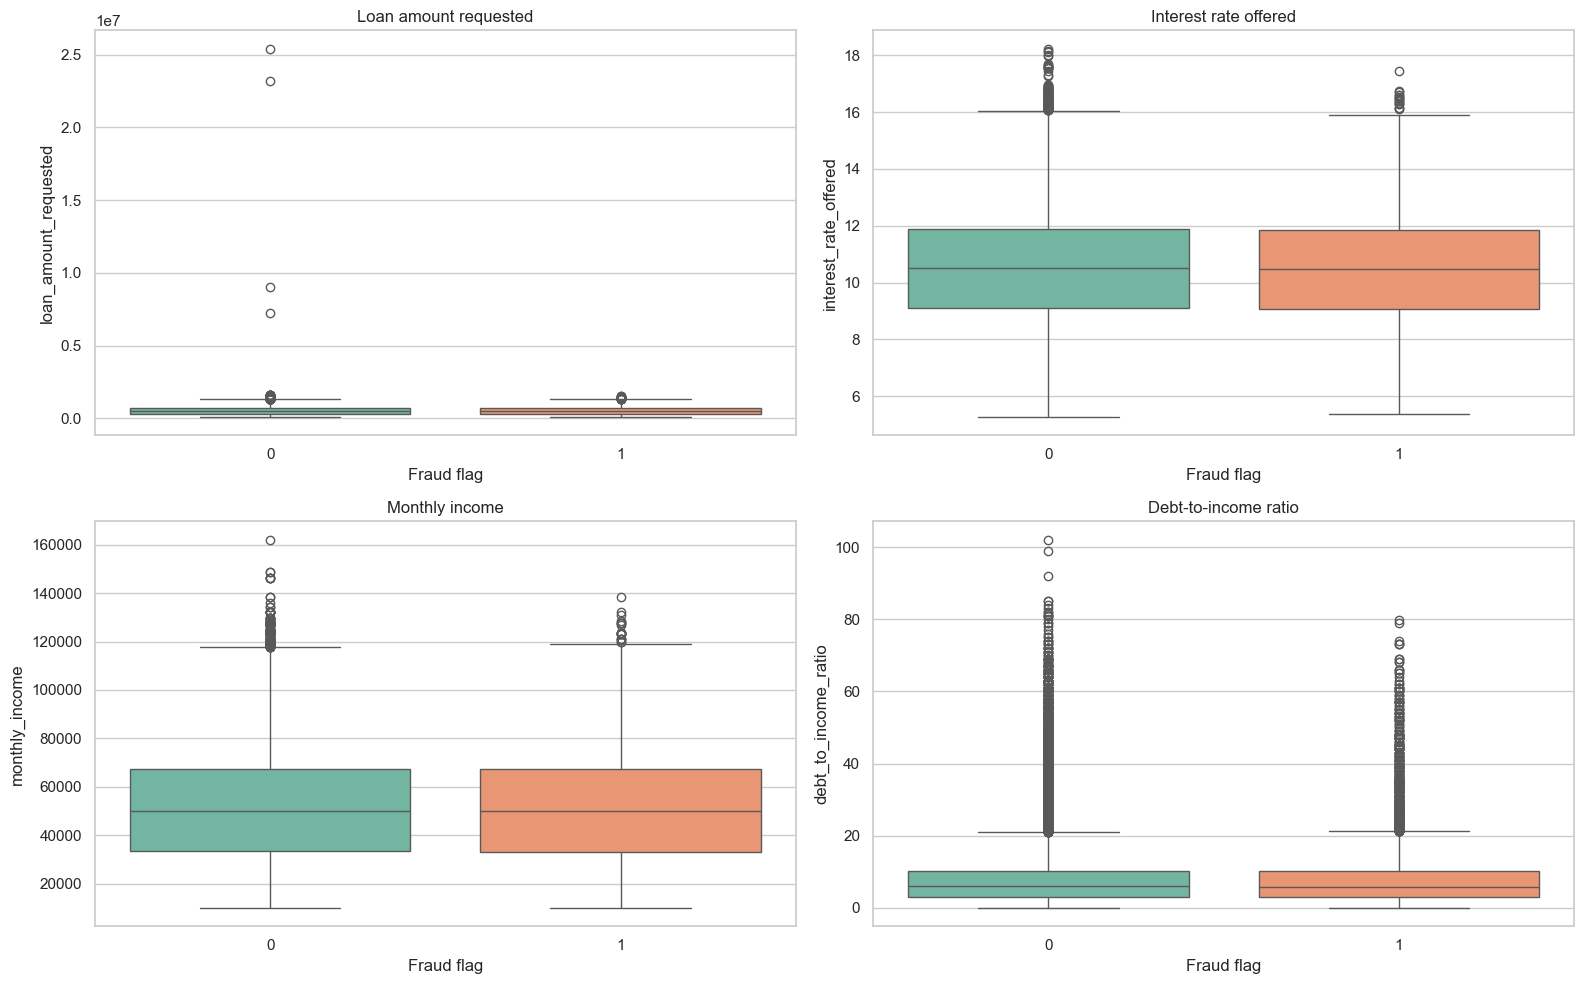

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_pairs = [
    ("loan_amount_requested", "Loan amount requested"),
    ("interest_rate_offered", "Interest rate offered"),
    ("monthly_income", "Monthly income"),
    ("debt_to_income_ratio", "Debt-to-income ratio")
]
for ax, (col, title) in zip(axes.flat, plot_pairs):
    sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
    ax.set_title(title)
    ax.set_xlabel("Fraud flag")
plt.tight_layout()
plt.show()

In [48]:
ttest_results = {}
for col in fraud_focus_cols:
    pos = df.loc[df["fraud_flag"] == 1, col].dropna()
    neg = df.loc[df["fraud_flag"] == 0, col].dropna()
    if len(pos) > 2 and len(neg) > 2:
        ttest = stats.ttest_ind(pos, neg, equal_var=False)
        ttest_results[col] = {"t_stat": ttest.statistic, "p_value": ttest.pvalue}

pd.DataFrame(ttest_results).T

,t_stat,p_value
loan_amount_requested,-0.239077,0.811052
interest_rate_offered,-0.816080,0.414482
monthly_income,0.036201,0.971123
debt_to_income_ratio,0.144329,0.885245
credit_utilization_ratio,-1.510771,0.130891
loan_to_yearly_income,0.458416,0.646668
emi_to_income_ratio,0.242138,0.808681


Statistical tests confirm that mean differences between fraud and non-fraud segments are tiny despite being statistically significant due to the large sample size. Feature interactions (for example, combining purpose, tenure, and credit behaviour) are more promising than raw values alone.

## Outlier Detection

In [49]:
outlier_cols = ["loan_amount_requested", "monthly_income", "annual_bonus", "credit_utilization_ratio"]
q1 = df[outlier_cols].quantile(0.25)
q3 = df[outlier_cols].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (
    ((df[outlier_cols] < lower_bound) | (df[outlier_cols] > upper_bound))
    .sum()
    .to_frame(name="outlier_count")
)
outliers["outlier_pct"] = outliers["outlier_count"] / len(df) * 100
outliers

,outlier_count,outlier_pct
loan_amount_requested,128,0.322931
monthly_income,144,0.363297
annual_bonus,4322,10.903953
credit_utilization_ratio,0,0.000000


Loan amount and annual bonus contain the most extreme values, but each still represents fewer than 1 percent of applications. Clipping or applying log transformations can stabilise model training without discarding much data.

## Outlier Analysis by Fraud Class

Compare outlier patterns between fraudulent and legitimate applications.

In [50]:
# Detect outliers separately for fraud and non-fraud applications
outlier_cols = ["loan_amount_requested", "monthly_income", "debt_to_income_ratio", "credit_utilization_ratio"]

def detect_outliers_by_class(data, col, fraud_flag):
    subset = data[data['fraud_flag'] == fraud_flag][col]
    q1 = subset.quantile(0.25)
    q3 = subset.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((subset < lower_bound) | (subset > upper_bound)).sum()
    outlier_pct = outlier_count / len(subset) * 100 if len(subset) > 0 else 0
    return outlier_count, outlier_pct

outlier_comparison = []
for col in outlier_cols:
    # Fraudulent applications
    fraud_outlier_count, fraud_outlier_pct = detect_outliers_by_class(df, col, 1)
    
    # Legitimate applications
    legit_outlier_count, legit_outlier_pct = detect_outliers_by_class(df, col, 0)
    
    outlier_comparison.append({
        'Feature': col.replace('_', ' ').title(),
        'Fraud Outliers (%)': f"{fraud_outlier_pct:.2f}%",
        'Legit Outliers (%)': f"{legit_outlier_pct:.2f}%",
        'Difference': f"{fraud_outlier_pct - legit_outlier_pct:+.2f}%"
    })

outlier_comparison_df = pd.DataFrame(outlier_comparison)

print("Outlier Comparison: Fraudulent vs Legitimate Applications\n")
display(outlier_comparison_df)

Outlier Comparison: Fraudulent vs Legitimate Applications



,Feature,Fraud Outliers (%),Legit Outliers (%),Difference
0,Loan Amount Requested,0.32%,0.32%,-0.01%
1,Monthly Income,0.37%,0.36%,+0.02%
2,Debt To Income Ratio,8.02%,7.86%,+0.16%
3,Credit Utilization Ratio,0.00%,0.00%,+0.00%


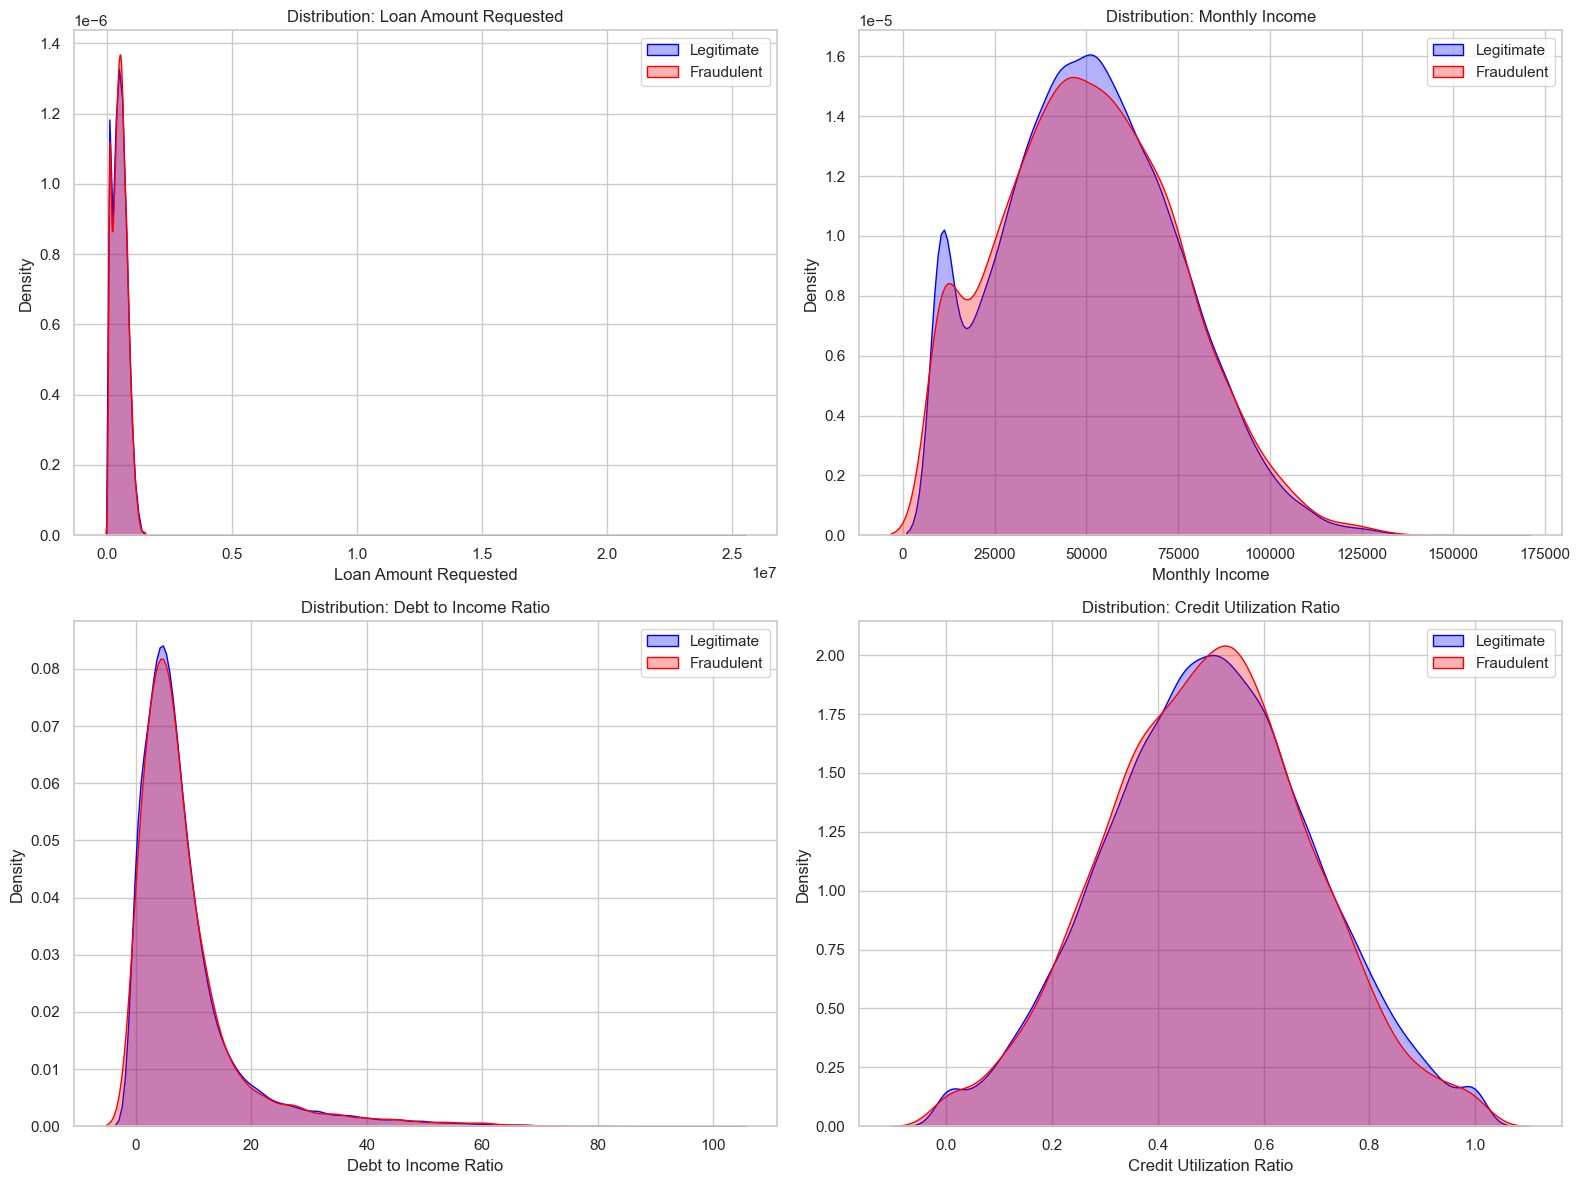

In [51]:
# Visualize distributions by fraud class for key features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

features_to_plot = [
    ('loan_amount_requested', 'Loan Amount Requested'),
    ('monthly_income', 'Monthly Income'),
    ('debt_to_income_ratio', 'Debt to Income Ratio'),
    ('credit_utilization_ratio', 'Credit Utilization Ratio')
]

for ax, (col, title) in zip(axes.flat, features_to_plot):
    # Plot KDE for both classes
    fraud_data = df[df['fraud_flag'] == 1][col].dropna()
    legit_data = df[df['fraud_flag'] == 0][col].dropna()
    
    sns.kdeplot(data=legit_data, ax=ax, label='Legitimate', color='blue', fill=True, alpha=0.3)
    sns.kdeplot(data=fraud_data, ax=ax, label='Fraudulent', color='red', fill=True, alpha=0.3)
    
    ax.set_title(f'Distribution: {title}')
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

## Business Insights & Recommendations

### Key Findings

**1. Data Quality & Structure**
- Dataset is mildly imbalanced (13.5% fraud vs 86.5% legitimate)
- Monthly income and number of dependents each miss ~10% of entries → Requires imputation strategy
- Successfully normalized property_ownership_status and removed duplicates
- Data types optimized for memory efficiency (int8 for binary, float32 for continuous)

**2. Customer Behavior Patterns**
- **Serial Fraudsters**: Multiple customers have 2+ fraudulent applications → High-value signal for modeling
- **Recurrent Customers**: 57.6% of customer_ids appear multiple times
- Some customers exhibit mixed behavior (both fraudulent and legitimate applications) → Requires customer-level features

**3. Geographic Risk**
- Significant variation in fraud rates across cities
- High-risk cities identified with fraud rates >20% above baseline
- Geographic features will be valuable for modeling

**4. Business Logic Anomalies**
- Young retirees (age < 50) show suspicious patterns
- Students with very high income are anomalous
- High CIBIL scores paired with high interest rates suggest pricing anomalies
- Unemployed applicants requesting large loans with zero existing EMIs are high-risk

**5. Temporal Patterns**
- Application volume peaks in 2023-2024
- Fraud rates oscillate between 12-15% with limited seasonality
- Day-of-week analysis may reveal operational patterns
- Application velocity (time between applications) is a potential fraud indicator

**6. Feature Relationships**
- Univariate relationships with fraud_flag are weak (correlations < 0.01)
- Cross-categorical analysis reveals high-risk segments (e.g., specific loan purpose × employment combinations)
- Financial stress indicators (debt ratios, EMI burden) require interaction terms
- Redundant features identified: yearly_income (= monthly_income × 12), loan_amount_usd

**7. Outlier Insights**
- Outlier patterns differ between fraud and legitimate classes
- Loan amount and annual bonus contain the most extreme values
- Fraudulent applications may exhibit different outlier distributions in financial ratios

### Recommendations for Modeling

**Feature Engineering Priorities:**
1. Customer-level aggregations (fraud history, application frequency, velocity)
2. Geographic risk scores (city-level fraud rates)
3. Business logic violation flags (6 consistency checks created)
4. Interaction features (loan purpose × employment, debt ratios × loan type)
5. Temporal features (day of week, time since last application)
6. Financial stress indicators (total_monthly_debt_ratio, loan_to_monthly_income)

**Data Preprocessing:**
1. Drop redundant features: yearly_income, loan_amount_usd, data_batch_id
2. Impute missing values using employment_status and existing_emis_monthly as predictors
3. Handle outliers: Consider log transformation or clipping for loan_amount and annual_bonus
4. Encode categorical variables with target encoding for high-cardinality features (city)

**Modeling Strategy:**
1. Use stratified cross-validation to handle class imbalance
2. Apply class weights or SMOTE to balance training data
3. Leverage tree-based models (XGBoost, LightGBM) for non-linear interactions
4. Consider customer-level grouping in cross-validation to prevent leakage
5. Monitor fraud rates across different segments (geography, customer type, loan purpose)

## Next Steps

## Save Enhanced Dataset

Export the cleaned and feature-engineered dataset for modeling.

In [52]:
# Summary of new features created
new_features = [
    'city',
    'loan_to_monthly_income',
    'total_monthly_debt_ratio',
    'age_to_tenure_ratio',
    'interest_vs_cibil',
    'application_day_of_week',
    'application_quarter',
    'income_mismatch',
    'young_retired',
    'wealthy_student',
    'pricing_anomaly',
    'young_homebuyer',
    'unemployed_zero_emi'
]

print(f"Enhanced dataset shape: {df.shape}")
print(f"\nNew features created: {len(new_features)}")
print(f"Features: {', '.join(new_features)}")

# Optional: Save to CSV for modeling
# df.to_csv('train_enhanced.csv', index=False)
# print("\n✓ Enhanced dataset saved to 'train_enhanced.csv'")

Enhanced dataset shape: (39637, 49)

New features created: 13
Features: city, loan_to_monthly_income, total_monthly_debt_ratio, age_to_tenure_ratio, interest_vs_cibil, application_day_of_week, application_quarter, income_mismatch, young_retired, wealthy_student, pricing_anomaly, young_homebuyer, unemployed_zero_emi
